In [1]:
%matplotlib inline

import io, os, sys, types, pickle, warnings, time
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import scipy.optimize as opt
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from matplotlib import colors as mcolors
import matplotlib.pylab as pl

import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
module_path = os.getcwd()
if module_path not in sys.path:
    sys.path.append(module_path)
import functions as my_func
import plots as my_plot
master_path = os.path.dirname(module_path)

In [3]:
""" Params """
cat_color = {'Confirmed':'tab:blue', 
              'Deaths':'tab:red', 
              'Recovered':'tab:green', 
              'Active':'tab:orange', 
              'Positive':'tab:purple', 
              'Negative':'tab:olive', 
              'Democratic':'tab:blue', 
              'Republican':'tab:red',
              'Independent':'tab:green'}
cdra_cols = ['Confirmed', 'Deaths', 'Recovered', 'Active']
pn_cols = ['Positive', 'Negative']
party_cols = ['Democratic', 'Republican', 'Independent']

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
MILLION = 1000000
locator_param = 6

# today_csv = '04-15-2020.csv'
# today = '04/04/20'

https://lmfit.github.io/lmfit-py/model.html

In [4]:
"""Get Data"""

'Get Data'

In [5]:
### get summarized time series data
path_time_series = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_time_series')
folders, files = my_func.parse_folder_info(path_time_series)
df_global = pd.DataFrame()
df_US_ori = pd.DataFrame()
for file in files:
    if('.csv' in file):
        print(file)
        df_tmp = pd.read_csv(os.path.join(path_time_series, file))
        if(len(file.split('_')) > 1):
            cat = file.split('_')[3]
            df_tmp['Category'] = cat[0].upper()+cat[1:]
            if('global' in file):
                df_tmp = df_tmp.drop(labels = ['Lat', 'Long'], axis = 1)
                df_global = df_global.append(df_tmp)
            elif('US' in file):
                df_tmp = df_tmp.drop(labels = ['Lat', 'Long_', 'UID', 'iso2', 'iso3', 'code3', 'FIPS'], axis = 1)
                df_US_ori = df_US_ori.append(df_tmp)
df_global.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace = True)
time_str, time_datetime = my_func.get_time_columns(df_global.columns)
df_global = my_func.reformat_time(df_global)
df_US_ori = my_func.reformat_time(df_US_ori)

### get daily update
path_daily = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_daily_reports')
files_daily = my_func.get_file_paths(path_daily)
files_daily.sort(key=os.path.getmtime)
print(files_daily[-1].split('/')[-1])
df_today = pd.read_csv(files_daily[-1])
df_today.loc[df_today.loc[:,'Province_State'].isna(),'Province_State'] = 'N/A'

time_series_covid19_confirmed_global.csv
time_series_covid19_confirmed_US.csv
Errata.csv
time_series_covid19_recovered_global.csv
time_series_covid19_deaths_global.csv
time_series_covid19_deaths_US.csv
05-13-2020.csv


In [6]:
### get some other stats
path_covid_19_data = os.path.join(master_path, 'covid_19_data')
df_world_population = pd.read_csv(os.path.join(path_covid_19_data, 'world_population_stats.csv'), encoding = "ISO-8859-1", engine='python')
df_world_population.loc[:, 'Population'] = df_world_population.Population.astype('float')
df_world_population.set_index('Country_Region', inplace = True)
df_china_population = pd.read_csv(os.path.join(path_covid_19_data, 'China_population.csv'))
df_china_population.set_index('Province_State', inplace = True)

### consolidate confirmed/death data and world stats data
df_confirmed = df_global.groupby('Category').get_group('Confirmed').groupby('Country_Region').sum()[time_datetime]
df_deaths = df_global.groupby('Category').get_group('Deaths').groupby('Country_Region').sum()[time_datetime]
df_confirmed['New_Today'] = df_confirmed[time_datetime[-1]] - df_confirmed[time_datetime[-2]]
df_deaths['New_Today'] = df_deaths[time_datetime[-1]] - df_deaths[time_datetime[-2]]
df_ctry_today = my_func.get_df_ctry_today(df_confirmed, df_deaths, df_world_population, time_datetime)

In [7]:
### get US testing stats
# testing data source: The COVID tracking project (https://covidtracking.com/)
%time df_covid_tracking = pd.read_csv('https://covidtracking.com/api/v1/states/current.csv')
print(f'Time last checked: between {min(df_covid_tracking.checkTimeEt)} and {max(df_covid_tracking.checkTimeEt)}')
print(f'Update time: between {min(df_covid_tracking.lastUpdateEt)} and {max(df_covid_tracking.lastUpdateEt)}')
%time df_tests_states_daily = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')
%time df_tests_us_daily = pd.read_csv('https://covidtracking.com/api/v1/us/daily.csv')

# state stats data source: wikipedia
df_state_stats = pd.read_csv(os.path.join(path_covid_19_data, 'US_state_stats.csv'))
df_covid_tracking.set_index('state', inplace = True)
df_state_stats.set_index('state', inplace = True)

# daily testing data:
df_tests_us_daily.sort_values(by = 'date', inplace = True, ascending=False)
df_tests_us_daily['date'] = pd.to_datetime(df_tests_us_daily['date'].astype('str'), infer_datetime_format=True)
df_tests_states_daily['date'] = pd.to_datetime(df_tests_states_daily['date'].astype('str'), infer_datetime_format=True)
# df_tests_us_daily.set_index('date', inplace = True)
test_time_datetime = list(df_tests_us_daily['date'])

# state mapping
usstate_abbs_mapping = {}
for st_abb in df_state_stats.index:
    usstate_abbs_mapping[df_state_stats.loc[st_abb, 'State']] = st_abb
    usstate_abbs_mapping[st_abb] = df_state_stats.loc[st_abb, 'State']
    
# conslidate testing data and stat stats data
df_us_tests_today = my_func.consolidate_testing(df_covid_tracking, df_state_stats)

CPU times: user 29.9 ms, sys: 8.21 ms, total: 38.1 ms
Wall time: 547 ms
Time last checked: between 5/13 14:15 and 5/13 17:01
Update time: between 5/10 00:00 and 5/13 16:20
CPU times: user 42 ms, sys: 8.57 ms, total: 50.6 ms
Wall time: 652 ms
CPU times: user 22.6 ms, sys: 2.21 ms, total: 24.8 ms
Wall time: 406 ms


In [8]:
""" Global Recovered, death, and confirmed """

' Global Recovered, death, and confirmed '

In [9]:
df_total = df_global.groupby('Category').sum().loc[:,time_datetime]
df_total = my_func.reshape_dataframe(df_total, time_datetime)

Global Confirmed cases: max daily increase at 2020-04-17, GF > 1 for today (2020-05-13). Prediction: r=0.08, K = 3,888,822~8,550,832, R^2 = 1.00 ~ 0.98; Predicted peak increase at 2020-04-12 ~ 2020-05-13, max will be reached at 2020-07-28.
Global Deaths: max daily increase at 2020-04-17, GF > 1 for today (2020-05-13). Prediction: r=0.10, K = 307,034~314,153, R^2 = 1.00 ~ 1.00; peak increase at 2020-04-17 ~ 2020-04-17, CFR = 5.55%; max will be reached at 2020-07-30 ~ 2020-08-06.


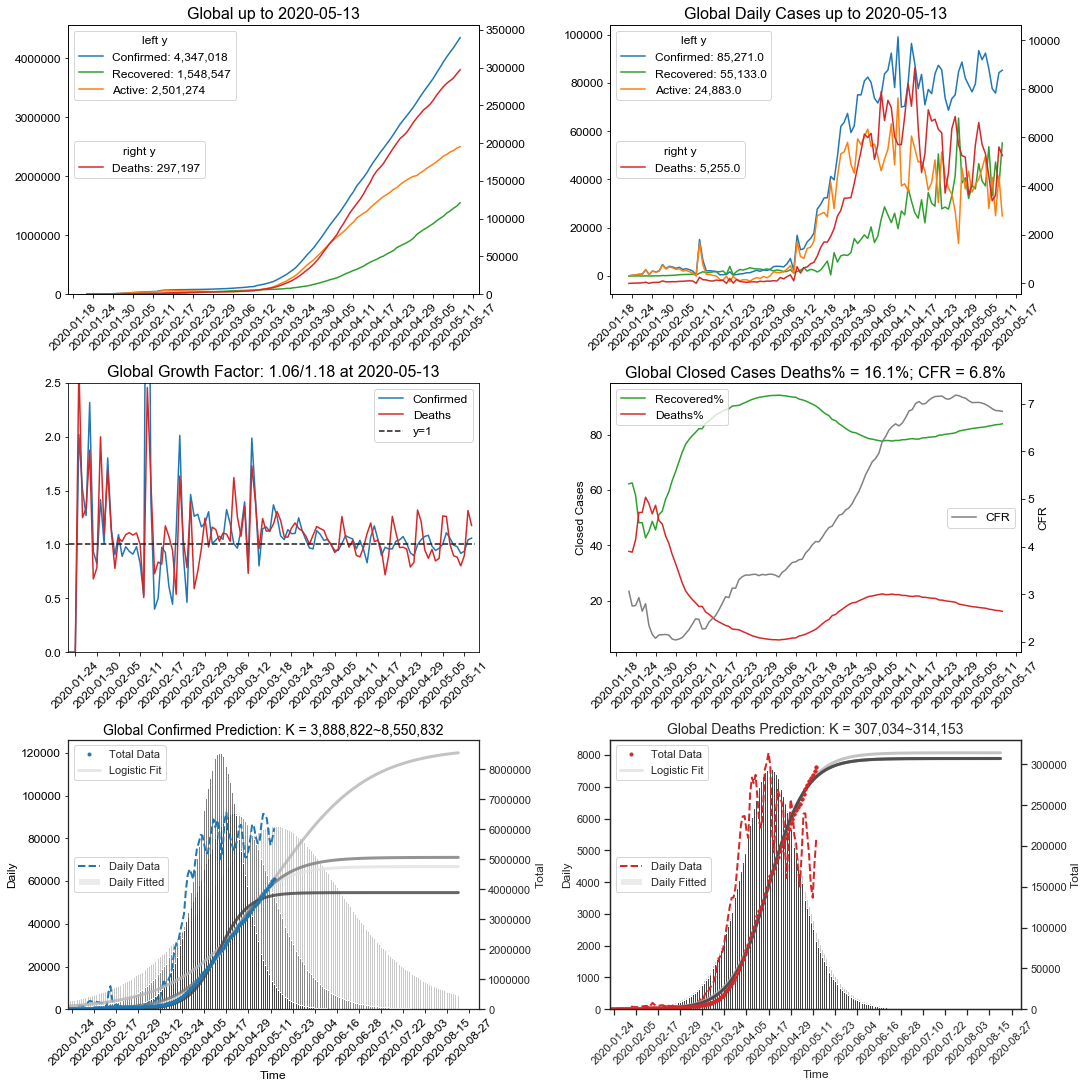

In [10]:
plotting_params = {
            'figsize':(15, 15),
            'time_series_cols' : ['Confirmed', 'Deaths', 'Recovered', 'Active'],
            'locator_param' : 6,
            'locator_param_future':12,
            'num_of_rols' : 3,
            'cat_color' : cat_color
        }
fitting_params = {
    'future':100,
    'p0_log' : (0.1, 1000, 0.01),
    'p0_exp':(0.1, 100),
    'bounds_c':((0,1000,0), (1, np.inf, 1)),
    'bounds_d':((0,1000,0), (1, np.inf, 1)),
    'death_to_confirmed':False,
    'thr_c':"total",
    'thr_d':'total',
    'method_c':'trf',
    'method_d':'trf',
    'plot_range':True,
}
tx1 = my_plot.plot_region(df_total, 'Global', plotting_params = plotting_params, is_fitting = True, fitting_params = fitting_params)

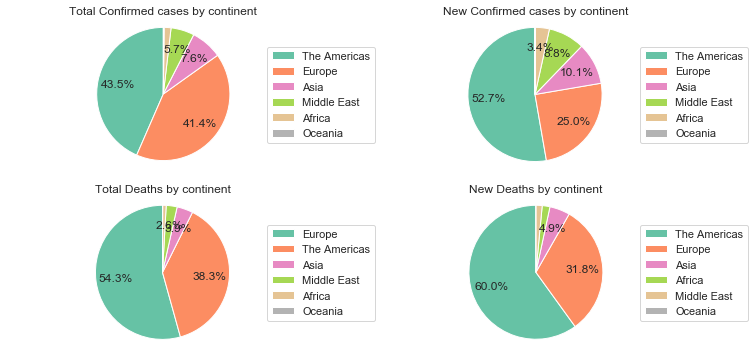

In [11]:
df_continents = df_ctry_today.groupby('Grouping1').sum()
my_plot.plot_continents(df_continents)

In [12]:
"""US"""

'US'

In [13]:
df_us = df_global.groupby('Country_Region').get_group('US').groupby('Category').sum().loc[:,time_datetime]
df_us = my_func.reshape_dataframe(df_us, time_datetime)
df_us_confirmed = df_US_ori.groupby('Category').get_group('Confirmed').groupby('Province_State').sum()
df_us_deaths = df_US_ori.groupby('Category').get_group('Deaths').groupby('Province_State').sum()
df_us_confirmed, df_us_deaths = my_func.reshape_dataframe_v2(df_us_confirmed, df_us_deaths, df_us_deaths['Population'], time_datetime)
# df_us_confirmed['New_Today'] = df_us_confirmed[time_datetime[-1]] - df_us_confirmed[time_datetime[-2]]
# df_us_deaths['New_Today'] = df_us_deaths[time_datetime[-1]] - df_us_deaths[time_datetime[-2]]
# df_us_confirmed['GF_today'] = (df_us_confirmed[time_datetime[-2]] - df_us_confirmed[time_datetime[-1]])/(df_us_confirmed[time_datetime[-3]] - df_us_confirmed[time_datetime[-2]])
# df_us_deaths['GF_today'] = (df_us_deaths[time_datetime[-2]] - df_us_deaths[time_datetime[-1]])/(df_us_deaths[time_datetime[-3]] - df_us_deaths[time_datetime[-2]])
# df_us_confirmed['Population'] = df_us_deaths['Population']
# df_us_confirmed['Per_Million'] = df_us_confirmed[time_datetime[-1]]/(df_us_confirmed['Population']/MILLION)
# df_us_deaths['Per_Million'] = df_us_deaths[time_datetime[-1]]/(df_us_deaths['Population']/MILLION)
# df_us_confirmed[~np.isfinite(df_us_confirmed)] = 0
# df_us_deaths[~np.isfinite(df_us_deaths)] = 0

US Confirmed cases: max daily increase at 2020-04-25, GF > 1 for today (2020-05-13). Prediction: r=0.13, K = 1,069,077~1,831,885, R^2 = 1.00 ~ 0.94; Predicted peak increase at 2020-05-21 ~ 2020-06-04, max will be reached at 2020-07-14.
US Deaths: max daily increase at 2020-04-18, GF > 1 for today (2020-05-13). Prediction: r=0.10, K = 86,288~110,463, R^2 = 1.00 ~ 0.99; peak increase at 2020-06-01 ~ 2020-06-07, CFR = 6.47%; max will be reached at 2020-08-24.


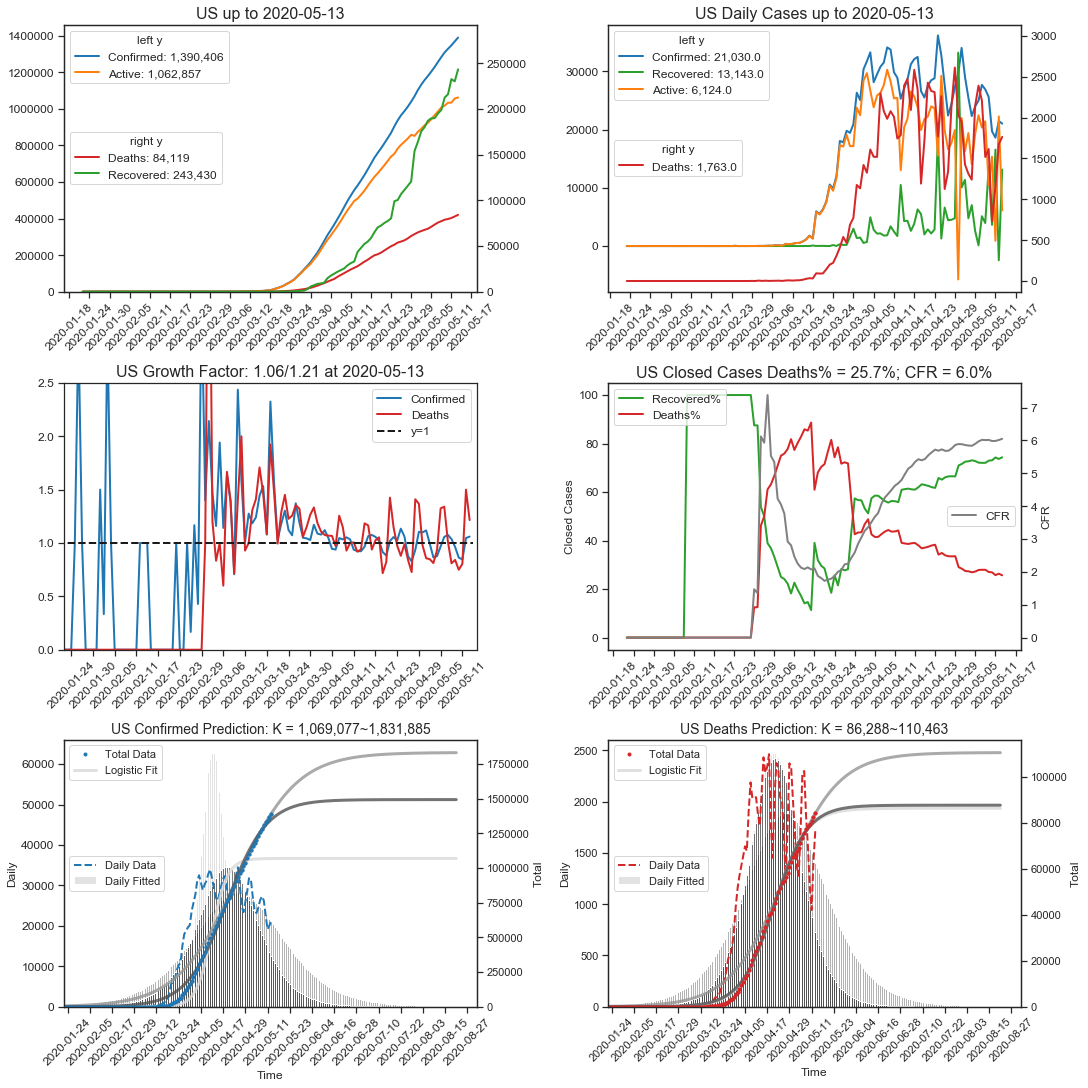

In [14]:
plotting_params = {
            'figsize':(15, 15),
            'time_series_cols' : ['Confirmed', 'Deaths', 'Recovered', 'Active'],
            'locator_param' : 6,
            'locator_param_future':12,
            'num_of_rols' : 3,
            'cat_color' : cat_color
        }
fitting_params = {
    'future':100,
    'p0_log' : (0.1, 1000, 0.01),
    'p0_exp':(0.1, 100),
    'bounds_c':((0,1000,0), (1, np.inf, 1)),
    'bounds_d':((0,1000,0), (1, np.inf, 1)),
    'death_to_confirmed':False,
    'thr_c':"total",
    'thr_d':'total',
    'method_c':'trf',
    'method_d':'trf',
    'plot_range':True,
}
my_plot.plot_region(df_us, 'US', plotting_params = plotting_params, 
                    is_fitting = True, show_recent = True, fitting_params = fitting_params)

In [15]:
df_us_confirmed.sort_values(by = time_datetime[-1], inplace = True, ascending = False)

California Confirmed cases: max daily increase at 2020-05-06, GF > 1 for today (2020-05-13). Prediction: r=0.07, K = 83,866~155,036, R^2 = 1.00 ~ 1.00; Predicted peak increase at 2020-06-03 ~ 2020-06-24, max will be reached at 2020-09-26.
California Deaths: max daily increase at 2020-04-23, GF > 1 for today (2020-05-13). Prediction: r=0.09, K = 3,240~4,604, R^2 = 1.00 ~ 1.00; peak increase at 2020-06-15 ~ 2020-06-24, CFR = 3.38%; max will be reached at 2020-08-09 ~ 2020-09-23.


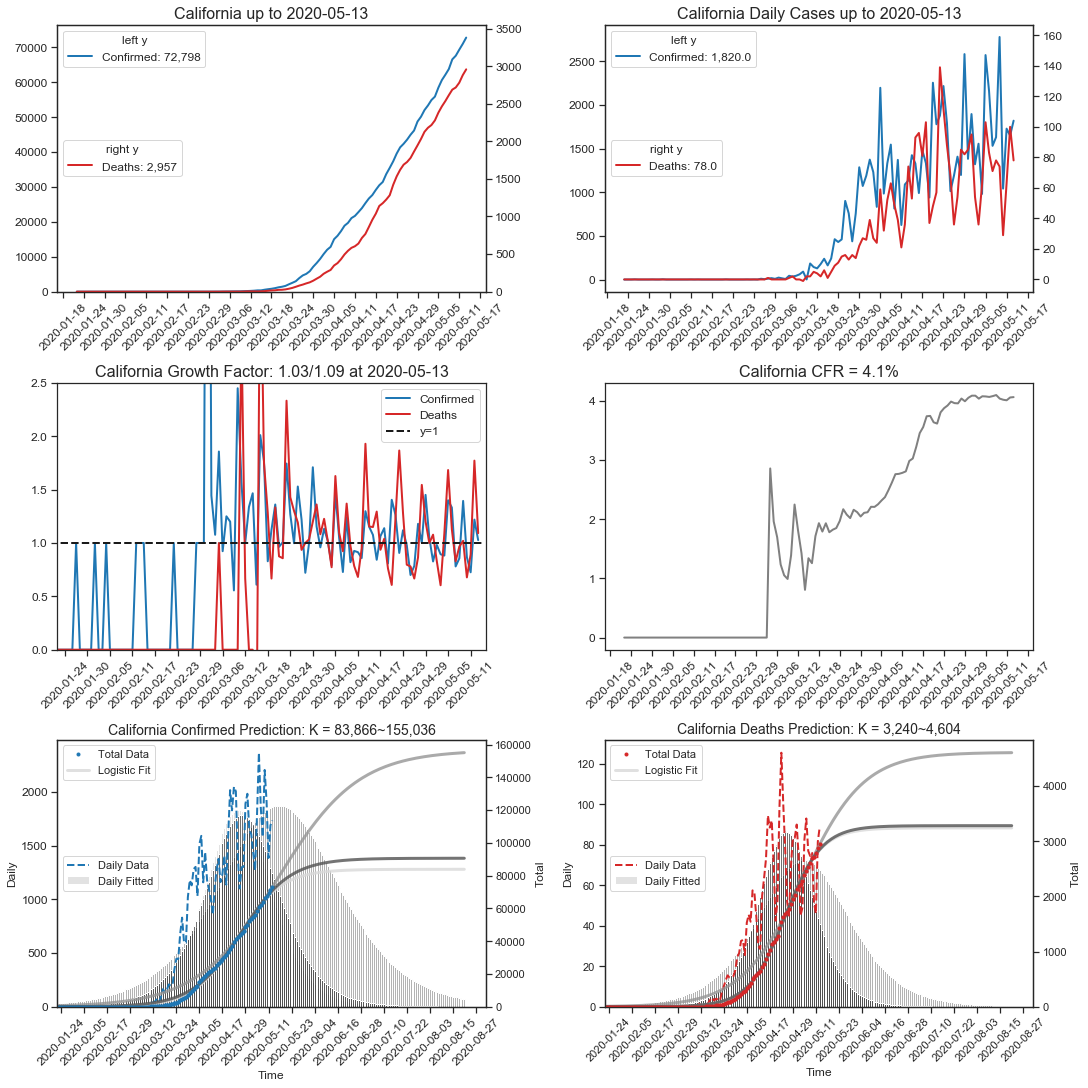

In [95]:
region = ['State', 'California']
if(region[0] == 'State'):
    df_region = df_US_ori.groupby('Province_State').get_group(region[1]).groupby('Category').sum()
elif(region[0] == 'County'):
    df_region = df_US_ori.groupby('Admin2').get_group(region[1]).groupby('Category').sum()
population = df_region.loc['Deaths', 'Population']
df_region = my_func.reshape_dataframe(df_region.loc[:,time_datetime], time_datetime, Population = population)

plotting_params = {
            'figsize':(15, 15),
            'time_series_cols' : ['Confirmed', 'Deaths'],
            'locator_param' : 6,
            'locator_param_future':12,
            'num_of_rols' : 3,
            'cat_color' : cat_color
        }
fitting_params = {
    'future':100,
    'p0_log' : (0.1, 1000, 0.01),
    'p0_exp':(0.1, 100),
    'bounds_c':((0,1000,0), (1, np.inf, 1)),
    'bounds_d':((0,1000,0), (1, np.inf, 1)),
    'death_to_confirmed':False,
    'thr_c':"rolling",
    'thr_d':'rolling',
    'method_c':'trf',
    'method_d':'trf',
    'plot_range':True,
}
my_plot.plot_region(df_region, region[1], plotting_params = plotting_params, is_fitting = True, fitting_params = fitting_params)

San Francisco Confirmed cases: max daily increase at 2020-04-11, GF > 1 for today (2020-05-13). Prediction: r=0.06, K = 2,080~11,876, R^2 = 0.99 ~ 0.99; Predicted peak increase at 2020-06-05 ~ 2020-10-02, max will be reached at 2020-08-13.


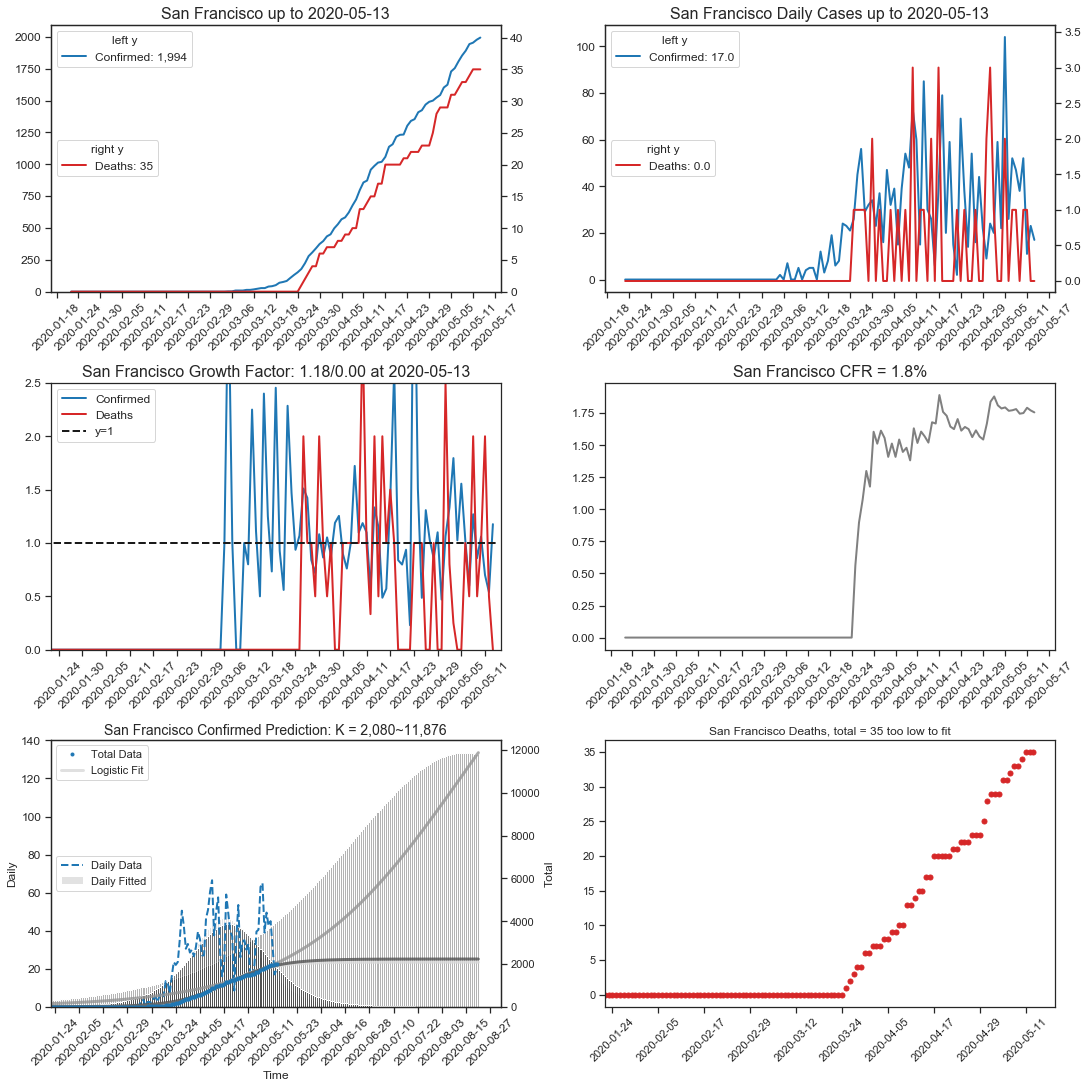

In [17]:
region = ['County', 'San Francisco']
if(region[0] == 'State'):
    df_region = df_US_ori.groupby('Province_State').get_group(region[1]).groupby('Category').sum()
elif(region[0] == 'County'):
    df_region = df_US_ori.groupby('Admin2').get_group(region[1]).groupby('Category').sum()
population = df_region.loc['Deaths', 'Population']
df_region = my_func.reshape_dataframe(df_region.loc[:,time_datetime], time_datetime, Population = population)

plotting_params = {
            'figsize':(15, 15),
            'time_series_cols' : ['Confirmed', 'Deaths'],
            'locator_param' : 6,
            'locator_param_future':12,
            'num_of_rols' : 3,
            'cat_color' : cat_color
        }
fitting_params = {
    'future':100,
    'p0_log' : (0.1, 1000, 0.01),
    'p0_exp':(0.1, 100),
    'bounds_c':((0,1000,0), (1, np.inf, 1)),
    'bounds_d':((0,1000,0), (1, np.inf, 1)),
    'death_to_confirmed':False,
    'thr_c':"rolling",
    'thr_d':'rolling',
    'method_c':'trf',
    'method_d':'trf',
    'plot_range':True,
}
my_plot.plot_region(df_region, region[1], plotting_params = plotting_params, is_fitting = True, fitting_params = fitting_params)

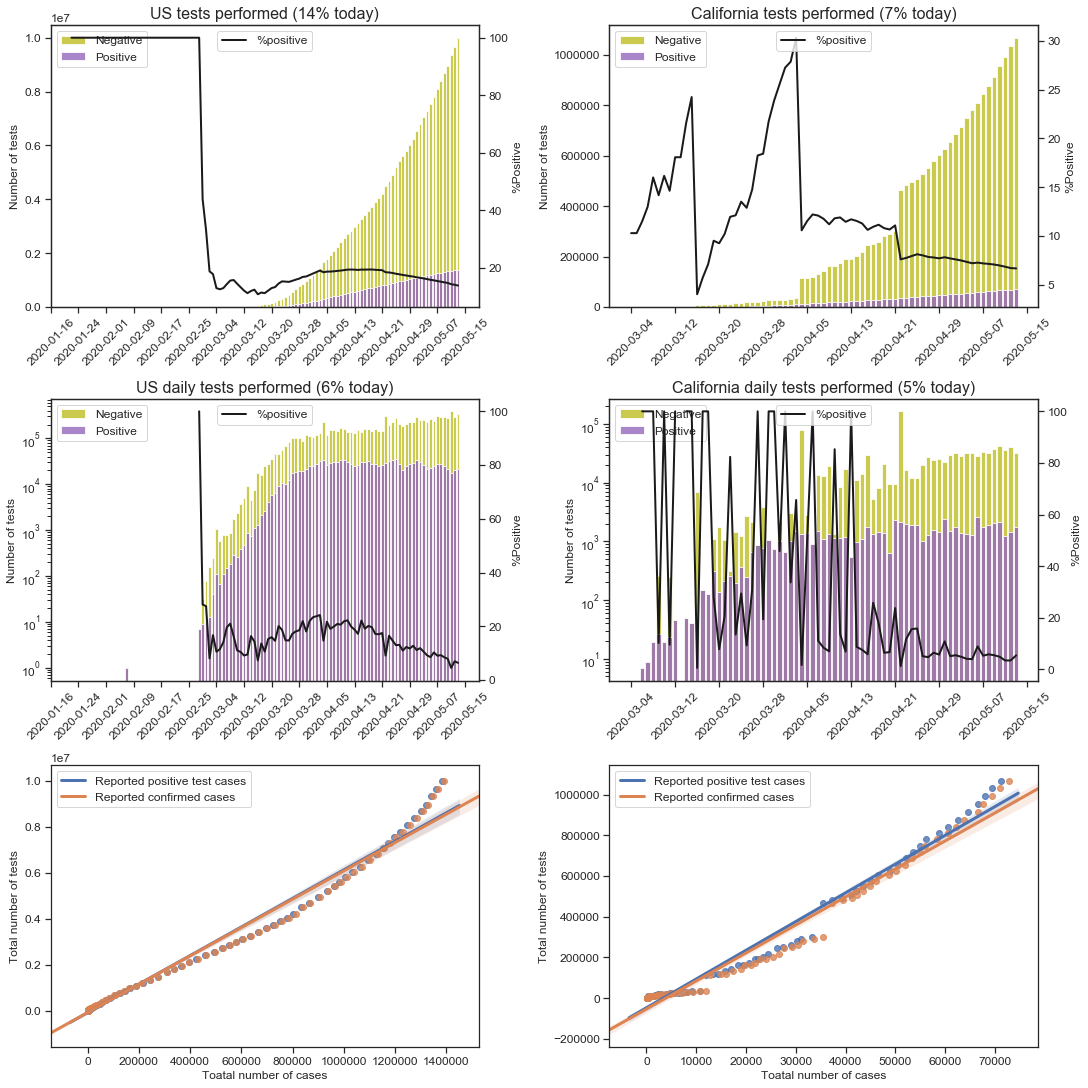

In [18]:
state = 'California'
st = usstate_abbs_mapping[state]

df_st = df_US_ori.groupby('Province_State').get_group(state).groupby('Category').sum()
df_st = my_func.reshape_dataframe(df_st.loc[:,time_datetime], time_datetime)

df_tests_st = df_tests_states_daily.groupby('state').get_group(st)

df_tests_us = my_func.reshape_dataframe_v3(df_tests_us_daily)
df_tests_st = my_func.reshape_dataframe_v3(df_tests_st)

my_plot.tests_us_vs_state(df_tests_us, df_tests_st, 
                          df_us, df_st, state, 
                          yscales = {1:'linear', 2:'log', 3:'linear', 4:'linear', 5:'linear', 6:'linear'}, 
                          plot_choice = 'Testing', figsize = (15, 15), 
                          resent_scales = False)

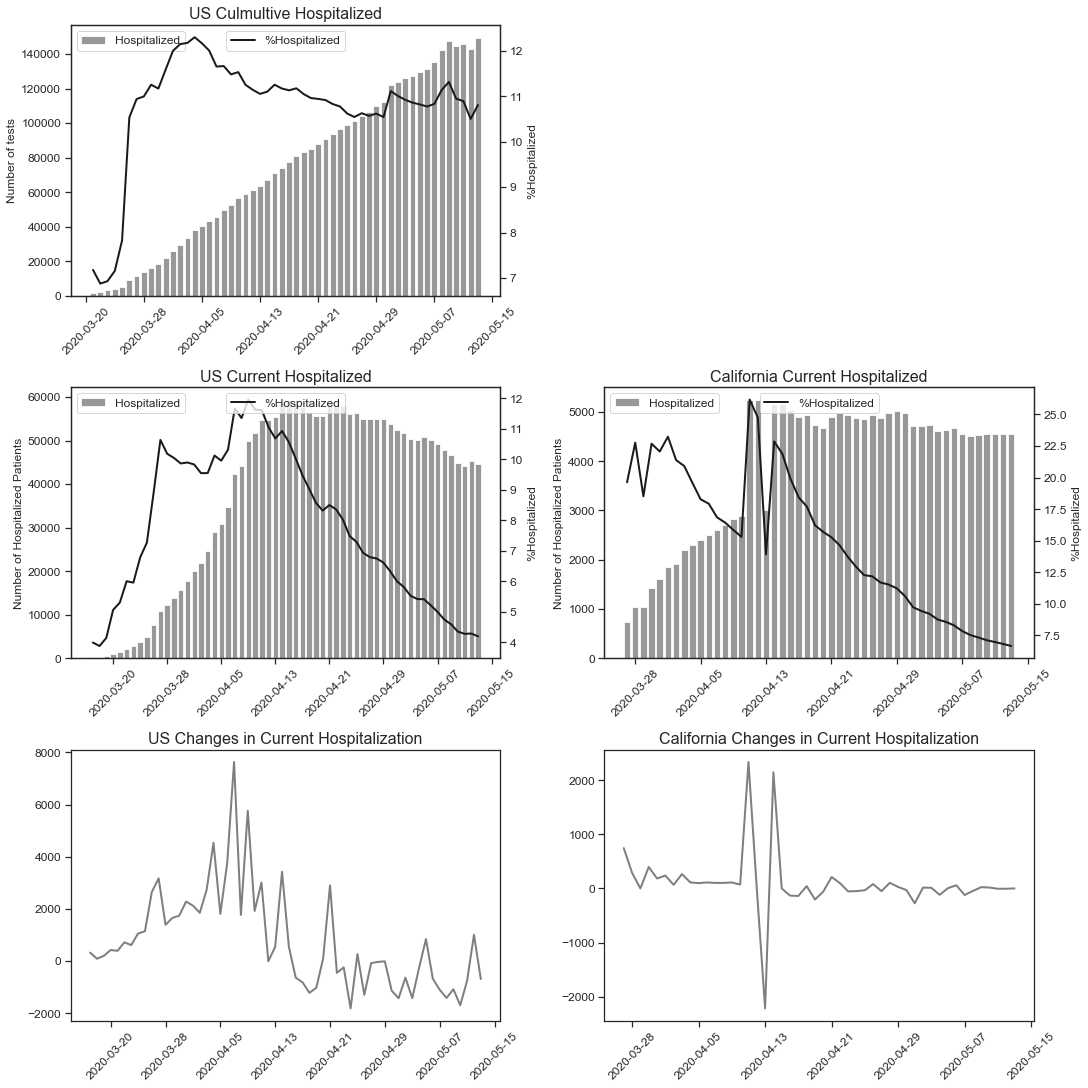

In [19]:
my_plot.tests_us_vs_state(df_tests_us, df_tests_st, 
                          df_us, df_st, state, 
                          yscales = {1:'linear', 2:'log', 3:'linear', 4:'linear', 5:'linear', 6:'linear'}, 
                          plot_choice = 'Hospitalization', figsize = (15, 15), 
                          resent_scales = False)

In [20]:
"""US by states"""

'US by states'

subplots: 0 1 2 3 4 5 6 7 8 9 

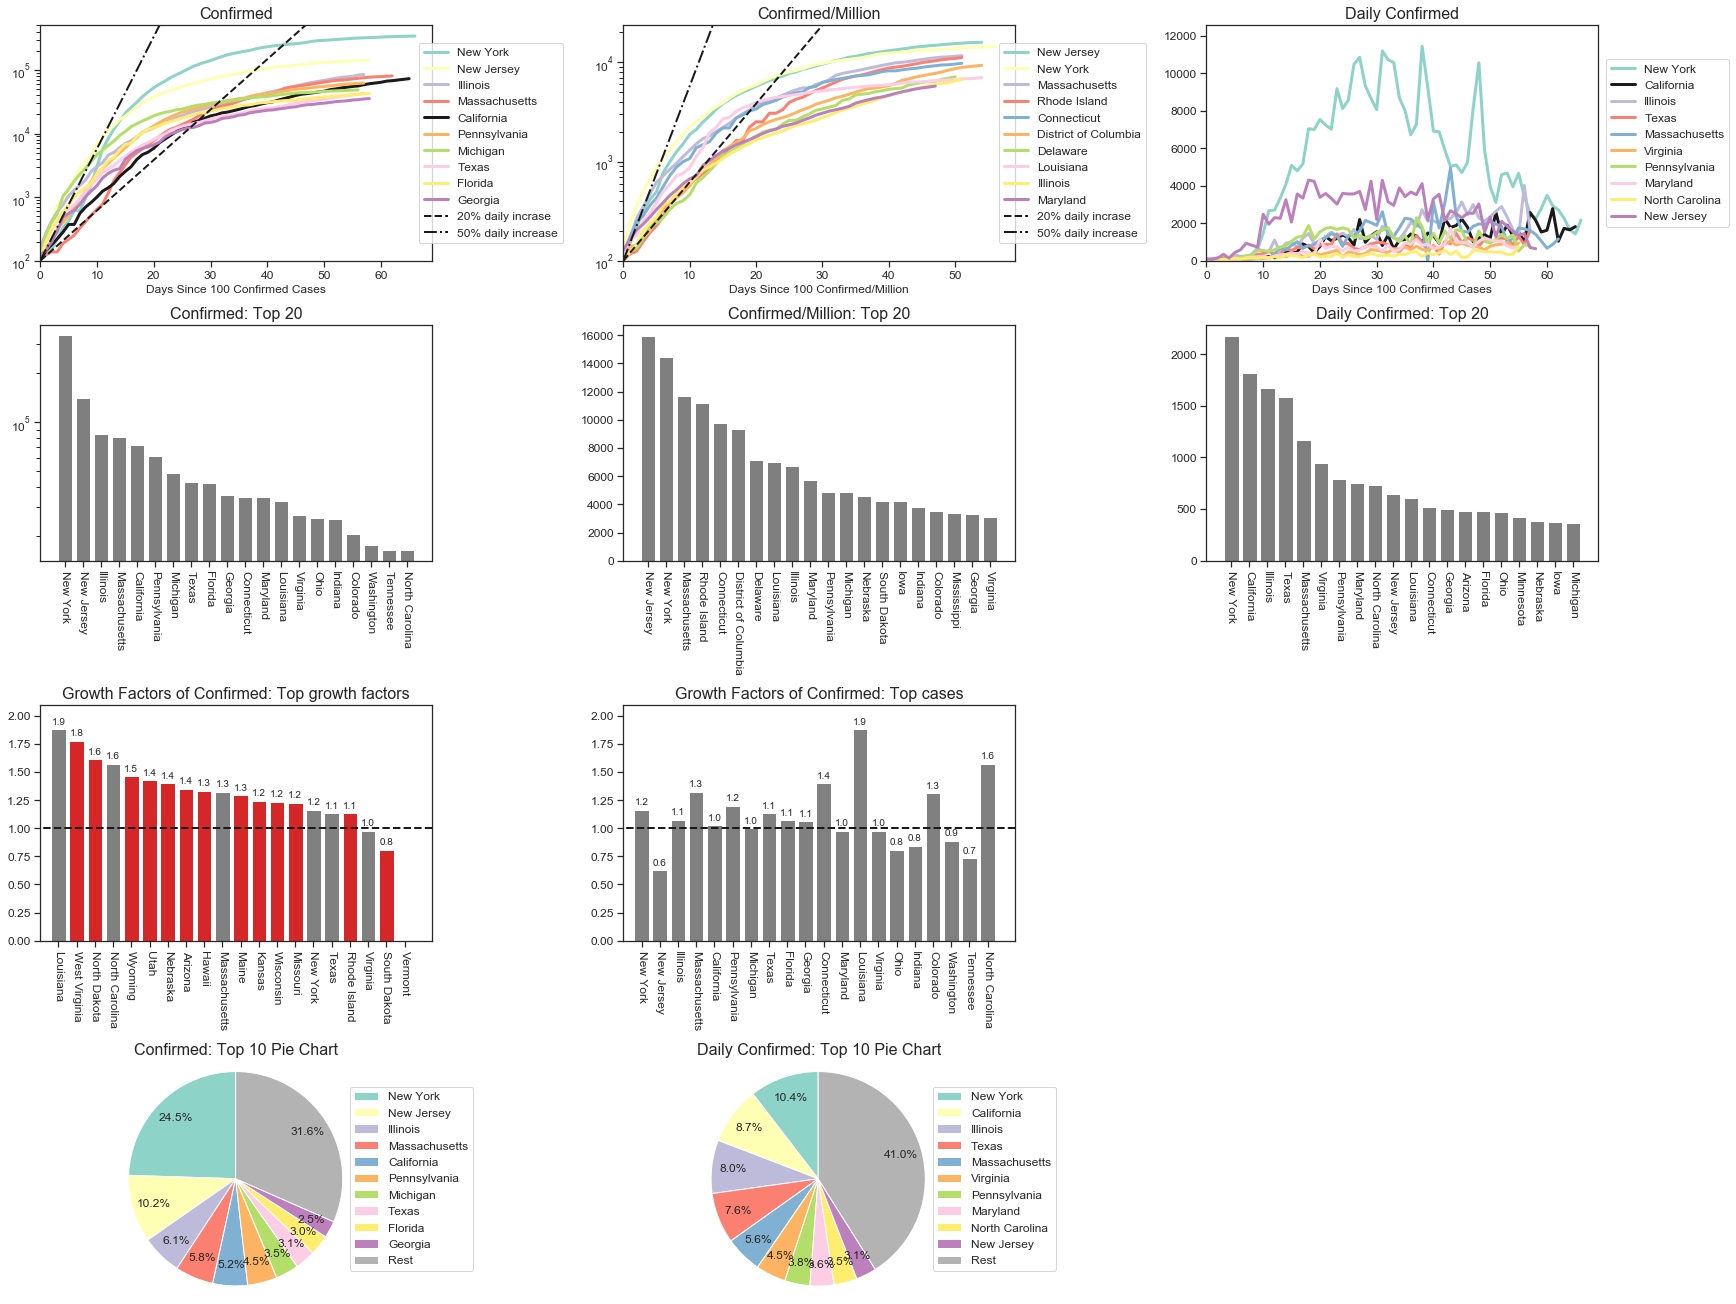

In [21]:
### plot us by states
yscales = ['log', 'log', 'linear', 'log', 'linear', 'linear', 'linear', 'linear']
k_lines = [0.2, 0.5, 0.2, 0.5]
my_plot.plot_by_regions(df_us_confirmed, df_us_deaths, 
                        time_datetime, special = 'California', 
                        k_lines = k_lines, yscales = yscales, 
                        figsize = (24, 18), plot_type = 'Confirmed')

subplots: 0 1 2 3 4 5 6 7 8 9 10 11 

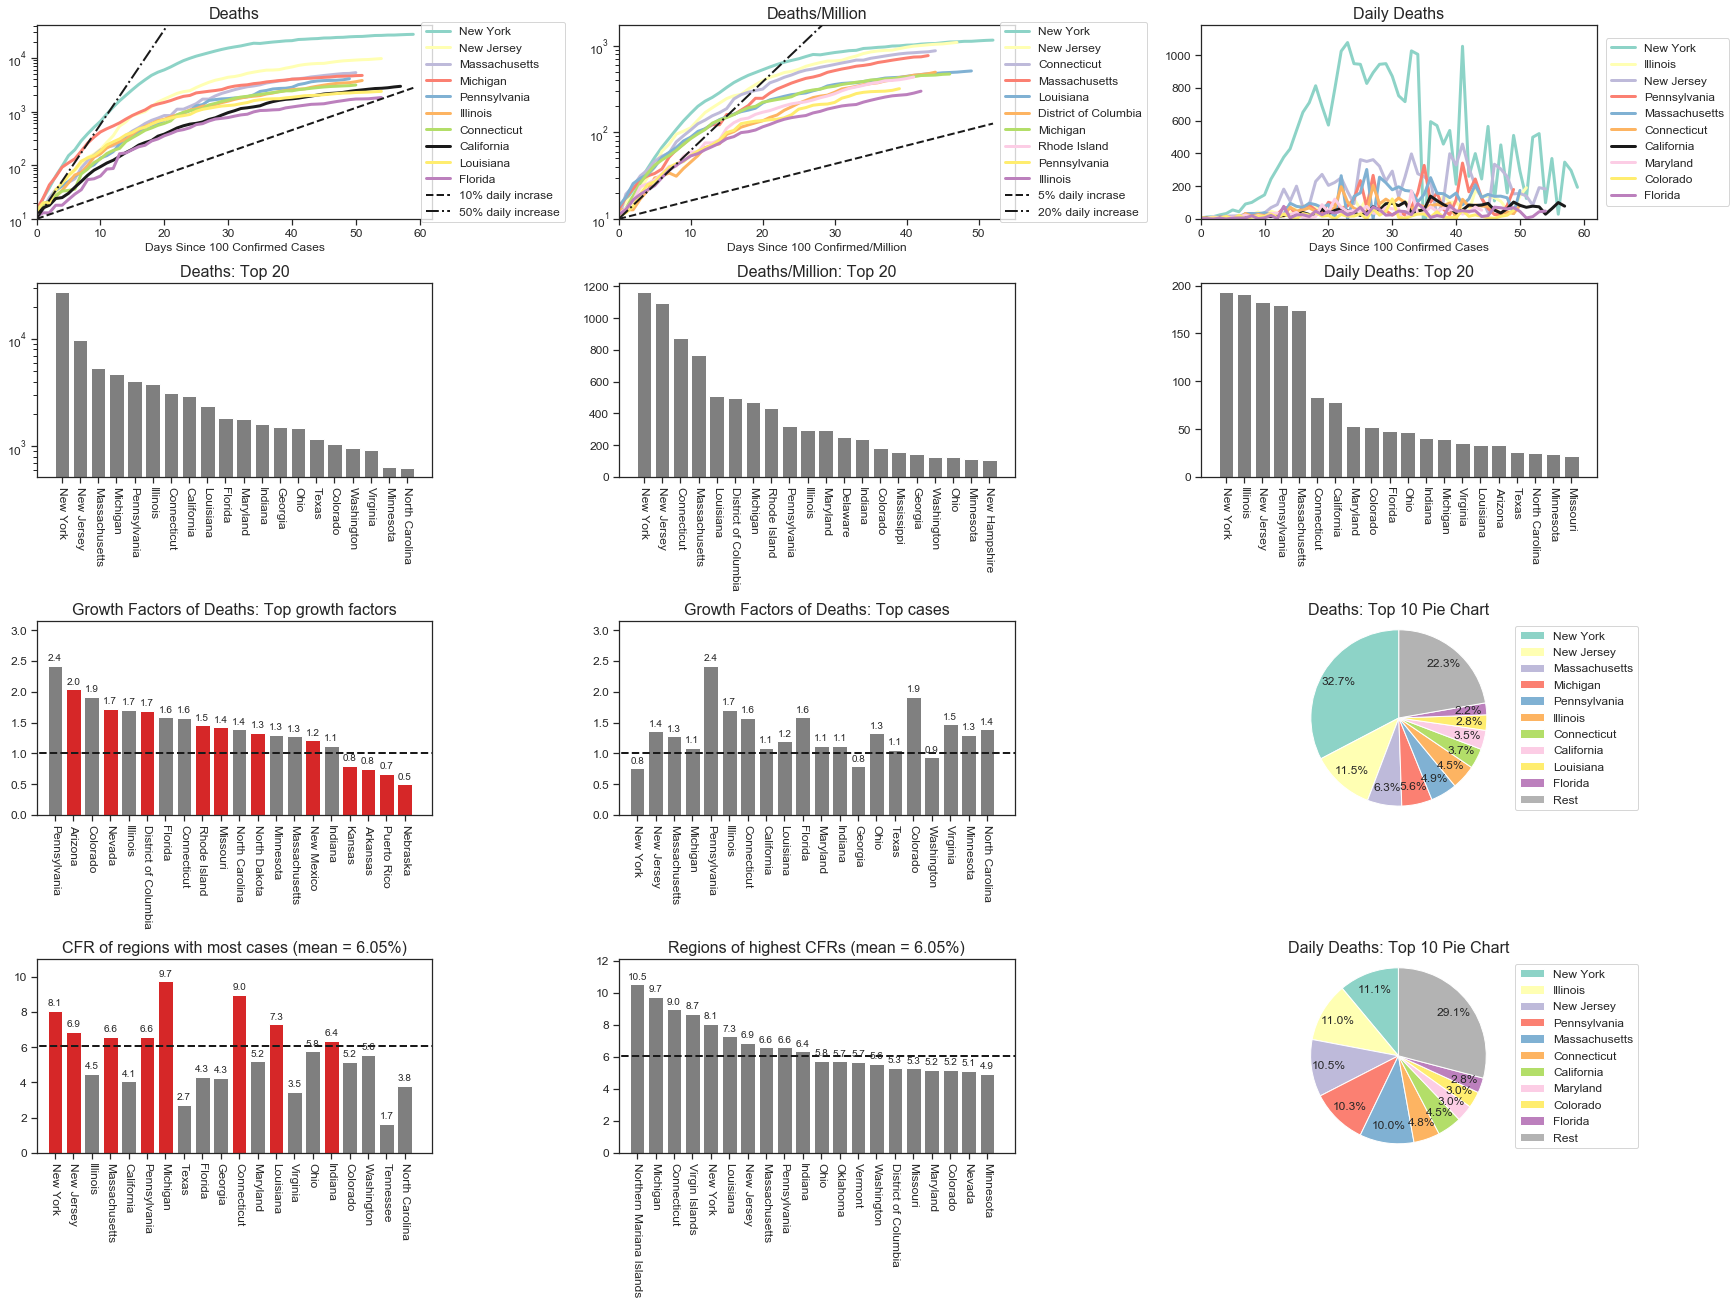

In [22]:
k_lines = [0.1, 0.5, 0.05, 0.2]
my_plot.plot_by_regions(df_us_confirmed, df_us_deaths, 
                        time_datetime, special = 'California', 
                        k_lines = k_lines, yscales = yscales, 
                        figsize = (24, 18), plot_type = 'Deaths')

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-

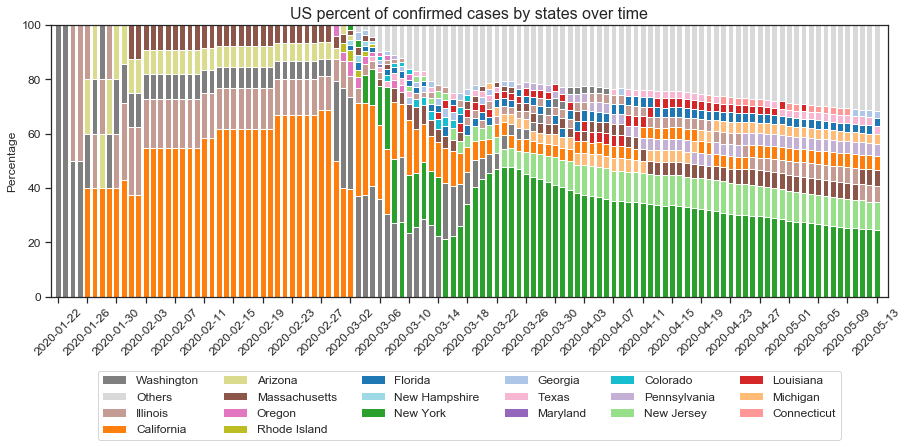

In [23]:
my_plot.plot_percentage_over_time(df_us_confirmed.loc[:,time_datetime], 10, 
                                  title = 'US percent of confirmed cases by states over time')

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-

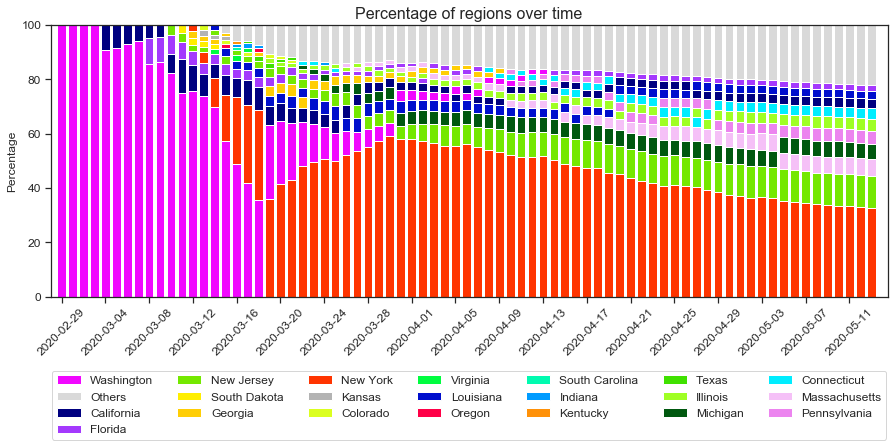

In [24]:
time_list = [time for time in time_datetime if df_us_deaths.loc[:,time].sum()>0]
my_plot.plot_percentage_over_time(df_us_deaths.loc[:,time_list], 10)

In [25]:
"""County Plot"""

'County Plot'

In [26]:
df_uscounty_conf = df_US_ori.groupby('Category').get_group('Confirmed').groupby('Combined_Key').sum()
df_uscounty_deaths = df_US_ori.groupby('Category').get_group('Deaths').groupby('Combined_Key').sum()
df_uscounty_conf, df_uscounty_deaths = my_func.reshape_dataframe_v2(df_uscounty_conf, df_uscounty_deaths, df_uscounty_deaths['Population'], time_datetime)

In [27]:
usstate_abbs_mapping['US Military'] = 'Military'
usstate_abbs_mapping['Veteran Hospitals'] = 'Veteran'

subplots: 0 1 2 3 4 5 6 7 8 9 

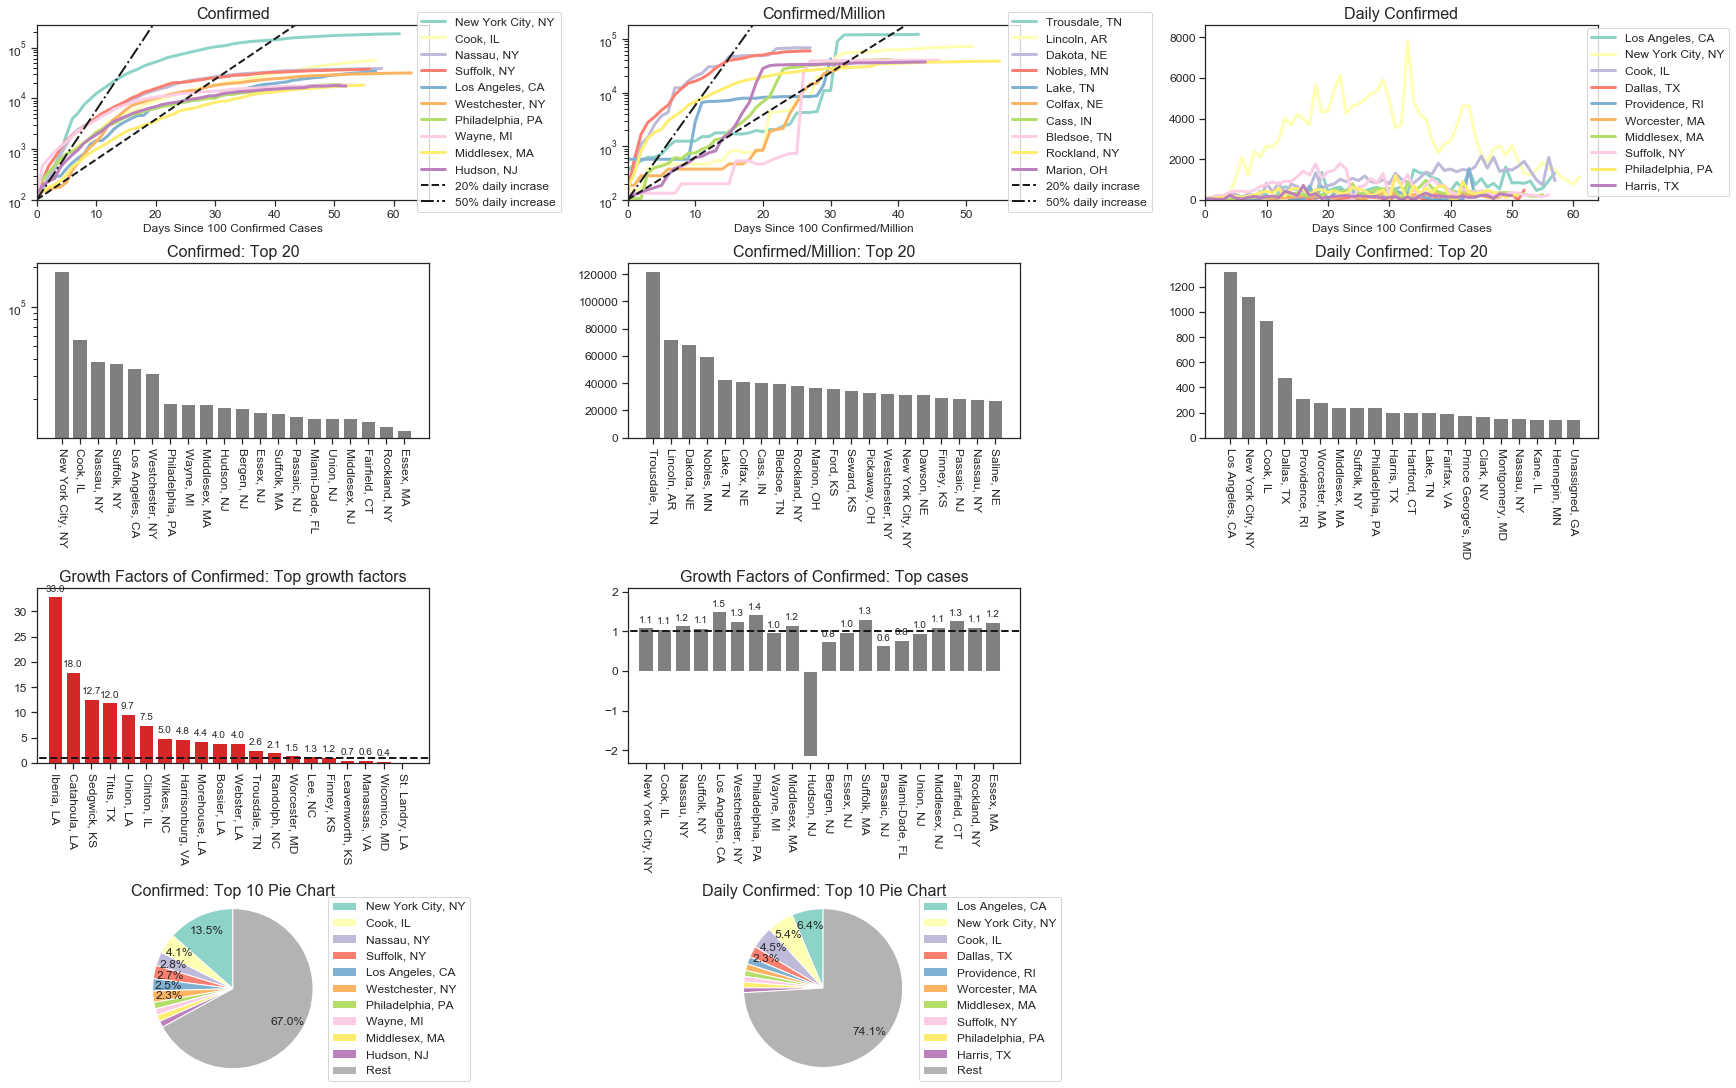

In [28]:
yscales = ['log', 'log', 'linear', 'log', 'linear', 'linear', 'linear', 'linear']
k_lines = [0.2, 0.5, 0.2, 0.5]
my_plot.plot_by_regions(df_uscounty_conf, df_uscounty_deaths, 
                        time_datetime, special = 'San Francisco', 
                        k_lines = k_lines, yscales = yscales, 
                        figsize = (24, 15), plot_type = 'Confirmed',
                        is_format_xtick = True, stat_abbs_mapping = usstate_abbs_mapping)

In [29]:
usstate_abbs_mapping['LA']

'Louisiana'

subplots: 0 1 2 3 4 5 6 7 8 9 10 11 

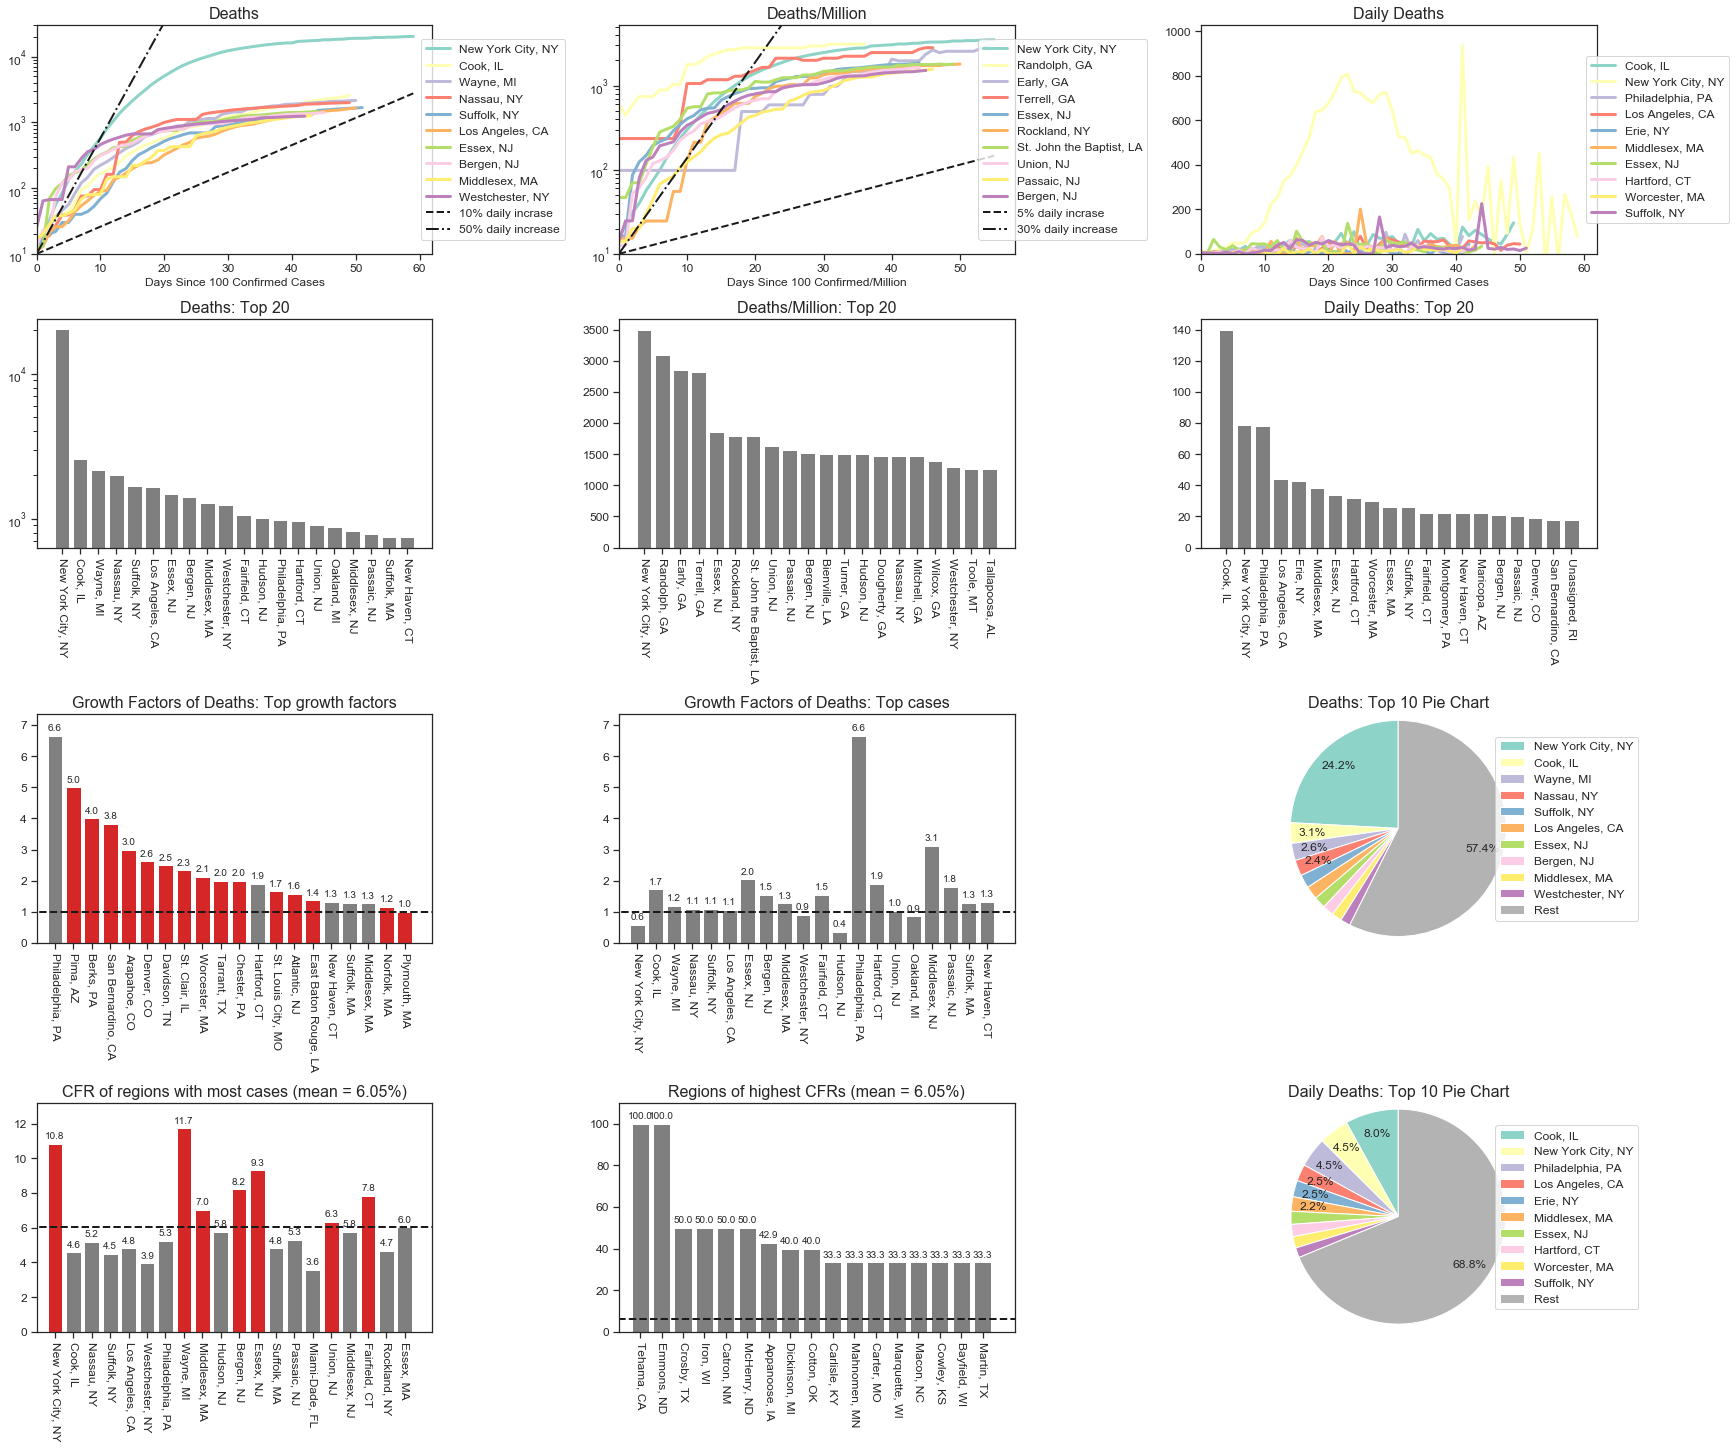

In [30]:
yscales = ['log', 'log', 'linear', 'log', 'linear', 'linear', 'linear', 'linear']
k_lines = [0.1, 0.5, 0.05, 0.3]
my_plot.plot_by_regions(df_uscounty_conf, df_uscounty_deaths, 
                        time_datetime, special = 'San Francisco', 
                        k_lines = k_lines, yscales = yscales, 
                        figsize = (24, 20), plot_type = 'Deaths',
                        is_format_xtick = True, stat_abbs_mapping = usstate_abbs_mapping)

subplot 1 2 3 4 5 6 7 8 

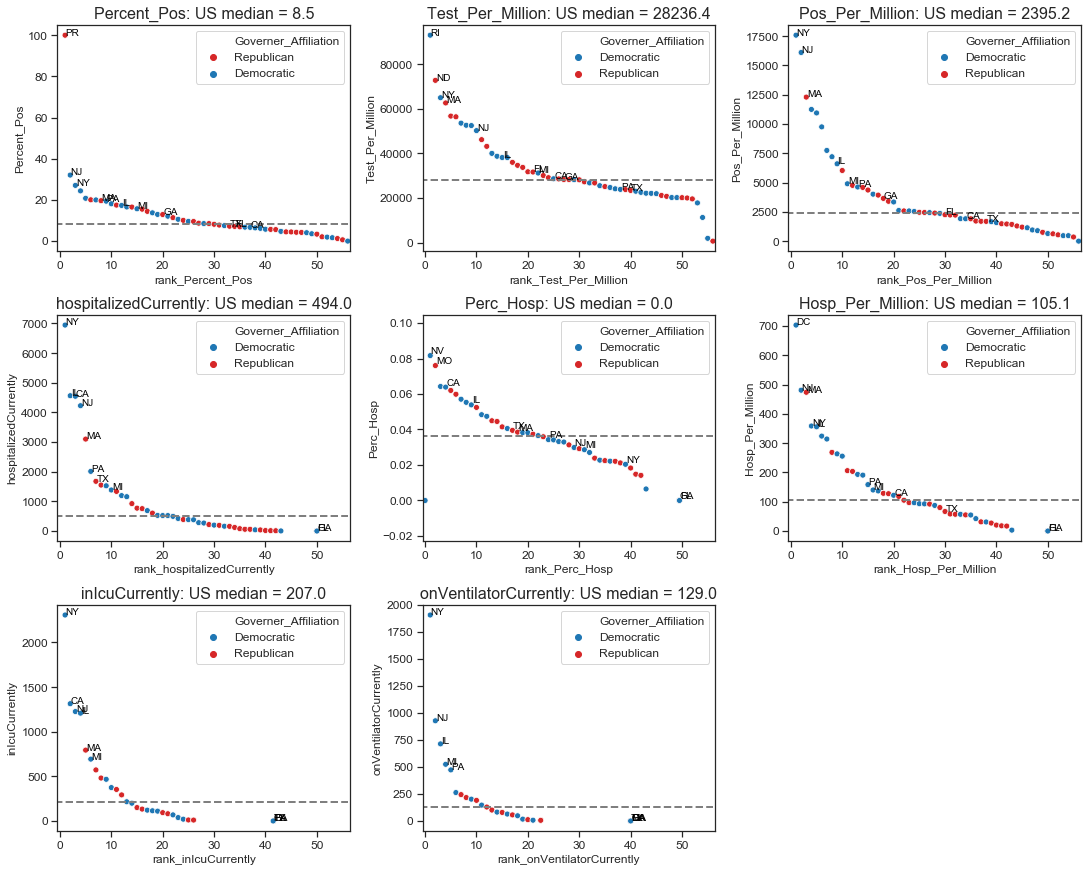

In [31]:
### tests
num_states = 10
df_us_confirmed.sort_values(by = time_datetime[-1], inplace = True, ascending=False)
my_plot.plot_us_tests_by_state(df_us_tests_today, df_tests_states_daily, 
                               usstate_abbs_mapping,
                              num_states = 10, plot_type = 'ranking',
                              figsize = (15, 12))

4 5 6 7 8 9 10 11 

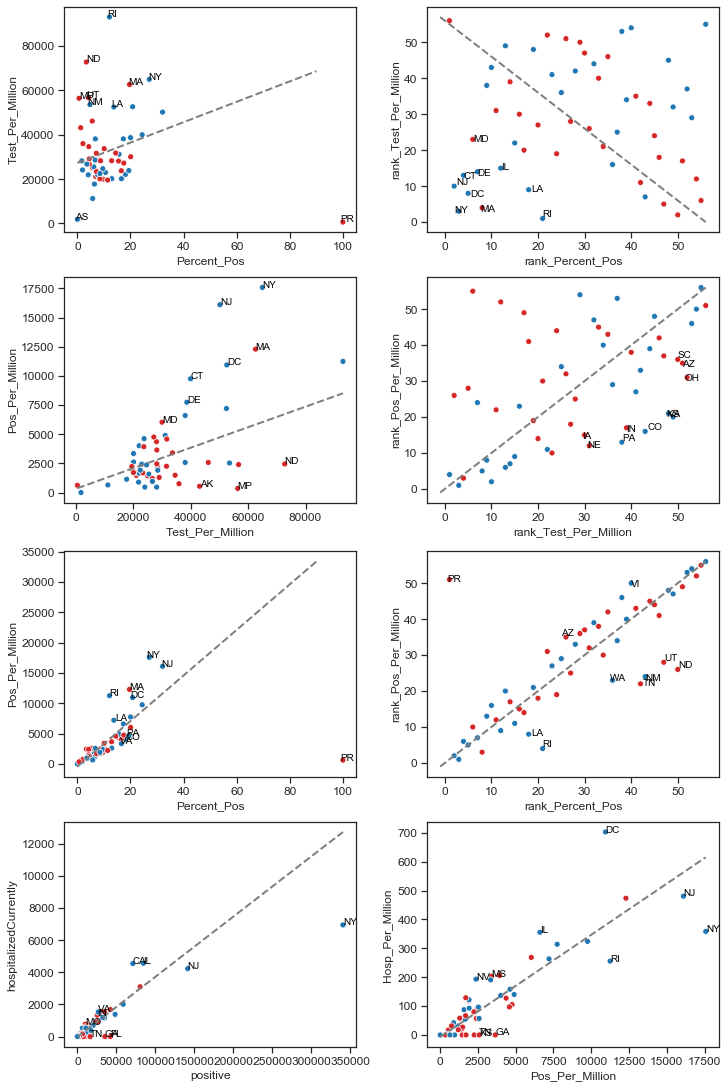

In [32]:
my_plot.plot_us_tests_by_state(df_us_tests_today, df_tests_states_daily, 
                               usstate_abbs_mapping,
                              num_states = 10, plot_type = 'relationship',
                              figsize = (10, 15))

7~9: 0 1 2 3 4 5 6 7 8 9 

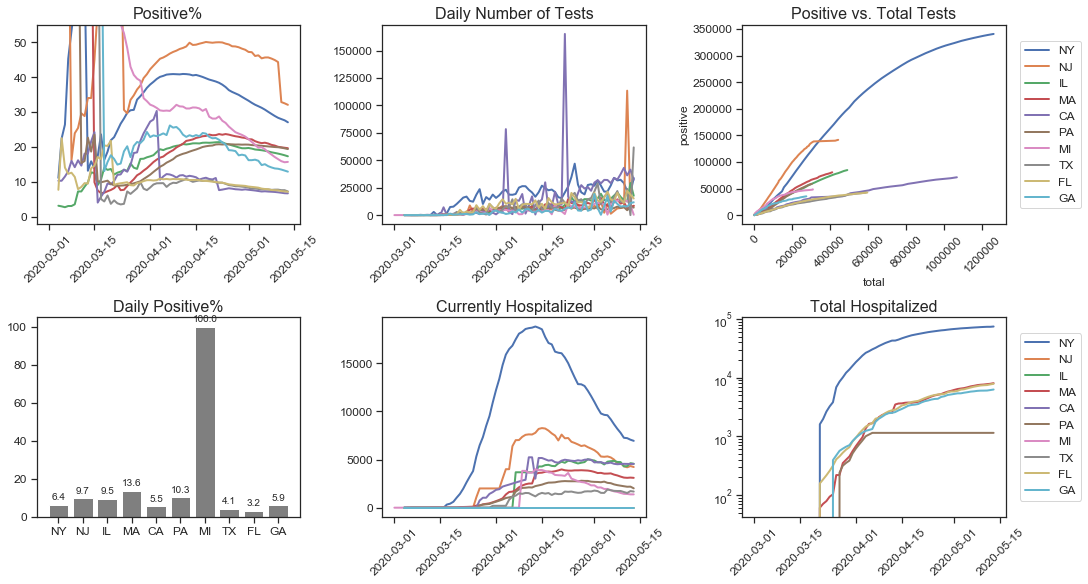

In [33]:
my_plot.plot_us_tests_by_state(df_us_tests_today, df_tests_states_daily, 
                               usstate_abbs_mapping,
                              num_states = 10, plot_type = 'states',
                              figsize = (15, 8))

In [34]:
"""County status for top 5 states"""

'County status for top 5 states'

In [35]:
# df_us_confirmed.sort_values(by = time_datetime[-1], inplace = True, ascending=False)
# states = list(df_us_confirmed.index[0:5])
# my_plot.county_plot(df_today, states, 10, (15, 25), 1)

In [36]:
"""bay area"""

'bay area'

States: Bay Area, 

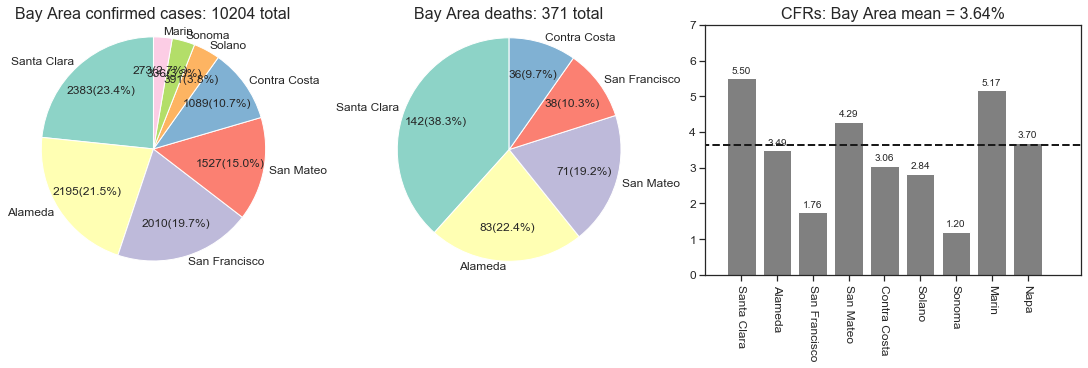

In [37]:
bay_area_counties = ['Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Francisco', 'San Mateo', 'Santa Clara', 'Solano', 'Sonoma']

df_state = df_today.groupby('Country_Region').get_group('US').groupby('Province_State').get_group('California').loc[:,]
df_state.set_index('Admin2', inplace = True)
df_bay_area_today = df_state.loc[bay_area_counties,:]
df_bay_area_today.loc[:,'CFR'] = df_bay_area_today.Deaths/df_bay_area_today.Confirmed*100
df_bay_area_today = df_bay_area_today.replace([np.inf, -np.inf], 0)
df_bay_area_today.reset_index(inplace = True)
df_bay_area_today['Province_State'] = 'Bay Area'

my_plot.county_plot(df_bay_area_today, ['Bay Area'], len(bay_area_counties), (15, 5), 2)

In [38]:
df_bay_area = pd.DataFrame(columns = df_US_ori.columns)
for county in df_US_ori.groupby('Admin2').groups:
    if(county in bay_area_counties):
        df_bay_area = df_bay_area.append(df_US_ori.groupby('Admin2').get_group(county))
df_bay_area = my_func.reshape_dataframe(df_bay_area.loc[:,time_datetime+['Category']].groupby('Category').sum(), time_datetime)


Bay Area Confirmed cases: max daily increase at 2020-04-05, new cases decreasing since 2020-05-10. Prediction: r=0.07, K = 10,185~18,368, R^2 = 1.00 ~ 0.99; Predicted peak increase at 2020-05-23 ~ 2020-06-16, max will be reached at 2020-08-17.
Bay Area Deaths: max daily increase at 2020-04-16, new cases decreasing since 2020-05-13. Prediction: r=0.04, K = 918~991, R^2 = 0.99 ~ 0.96; peak increase at 2020-07-11 ~ 2020-07-22, CFR = 7.26%; max will be reached at 2020-09-27.


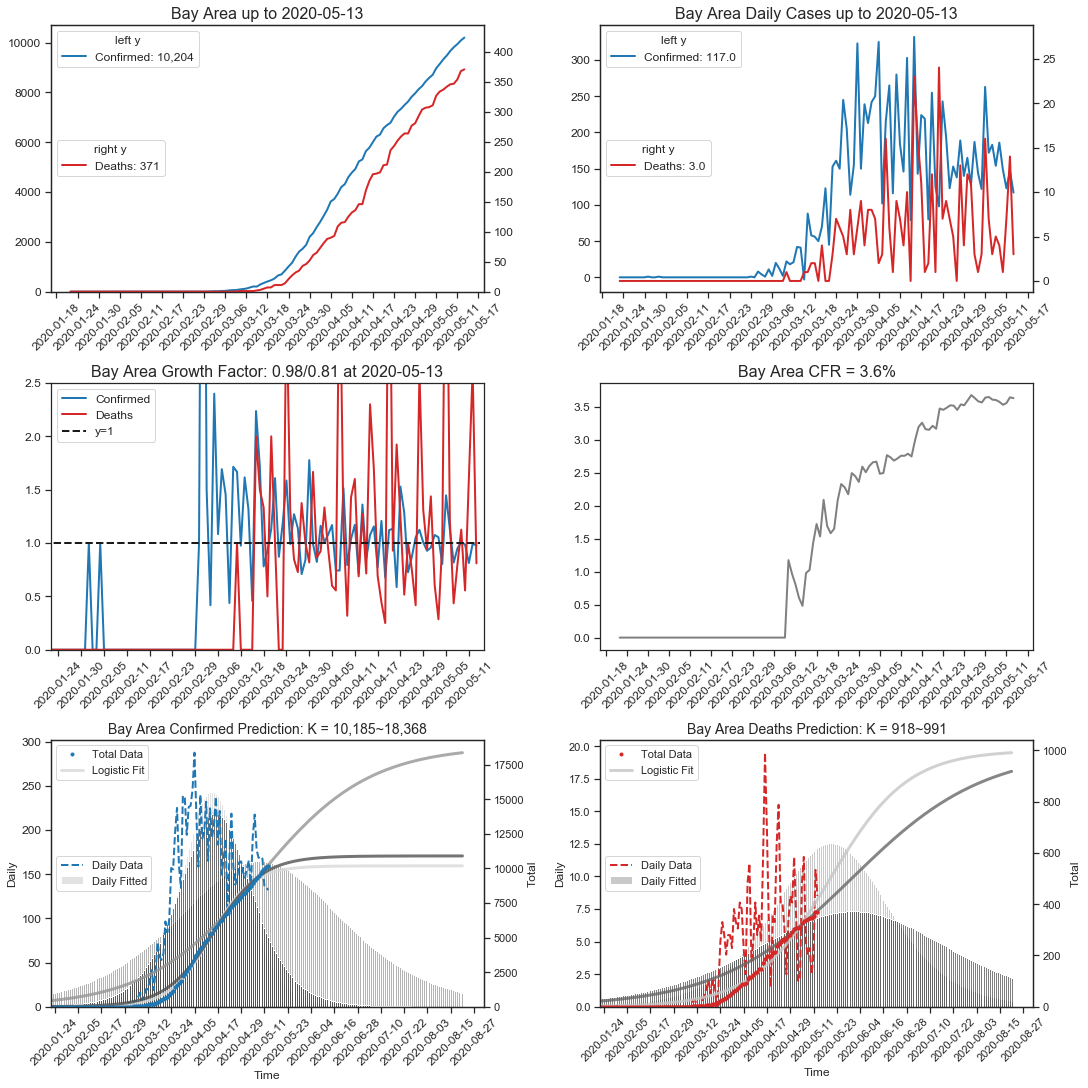

In [39]:
plotting_params = {
            'figsize':(15, 15),
            'time_series_cols' : ['Confirmed', 'Deaths'],
            'locator_param' : 6,
            'locator_param_future':12,
            'num_of_rols' : 3,
            'cat_color' : cat_color
        }
fitting_params = {
    'future':100,
    'p0_log' : (0.1, 1000, 0.01),
    'p0_exp':(0.1, 100),
    'bounds_c':((0,1000,0), (1, np.inf, 1)),
    'bounds_d':((0,1000,0), (1, np.inf, 1)),
    'death_to_confirmed':False,
    'thr_c':"rolling",
    'thr_d':'rolling',
    'method_c':'trf',
    'method_d':'trf',
    'plot_range':True,
}
my_plot.plot_region(df_bay_area, 'Bay Area', plotting_params = plotting_params, 
                    is_fitting = True, fitting_params = fitting_params)

In [40]:
""" World by countinent """

' World by countinent '

In [41]:
df_confirmed = df_global.groupby('Category').get_group('Confirmed').groupby('Country_Region').sum()[time_datetime]
df_deaths = df_global.groupby('Category').get_group('Deaths').groupby('Country_Region').sum()[time_datetime]
df_confirmed[['Grouping1', 'Grouping2']] = df_world_population[['Grouping1', 'Grouping2']]
df_deaths[['Grouping1', 'Grouping2']] = df_world_population[['Grouping1', 'Grouping2']]
df_confirmed_cont = df_confirmed.groupby('Grouping1').sum()[time_datetime]
df_deaths_cont = df_deaths.groupby('Grouping1').sum()[time_datetime]
df_confirmed_cont, df_deaths_cont = my_func.reshape_dataframe_v2(df_confirmed_cont, df_deaths_cont, df_world_population.groupby('Grouping1').sum()['Population'], time_datetime)

subplots: 0 1 2 3 4 5 6 7 8 9 

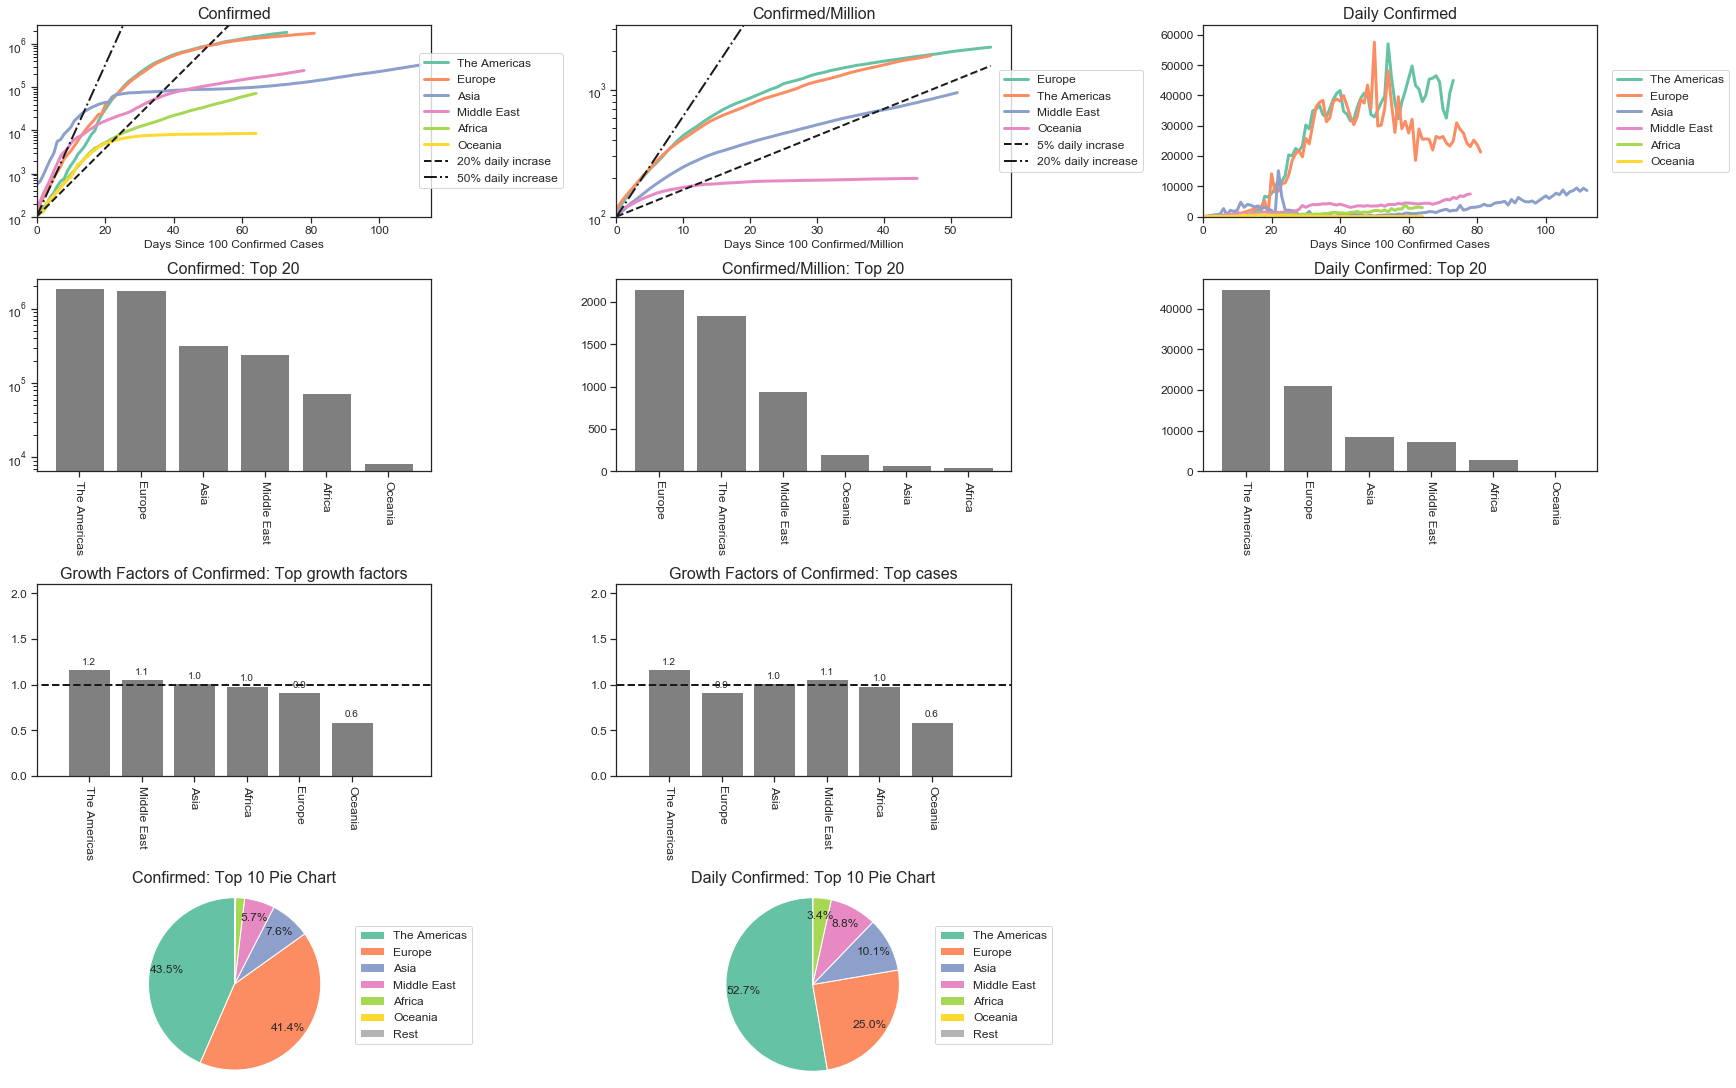

In [96]:
yscales = ['log', 'log', 'linear', 'log', 'linear', 'linear', 'linear', 'linear']
k_lines = [0.2, 0.5, 0.05, 0.2]
my_plot.plot_by_regions(df_confirmed_cont, df_deaths_cont, 
                        time_datetime, special = 'San Francisco', 
                        k_lines = k_lines, yscales = yscales, 
                        figsize = (24, 15), plot_type = 'Confirmed')

subplots: 0 1 2 3 4 5 6 7 8 9 10 11 

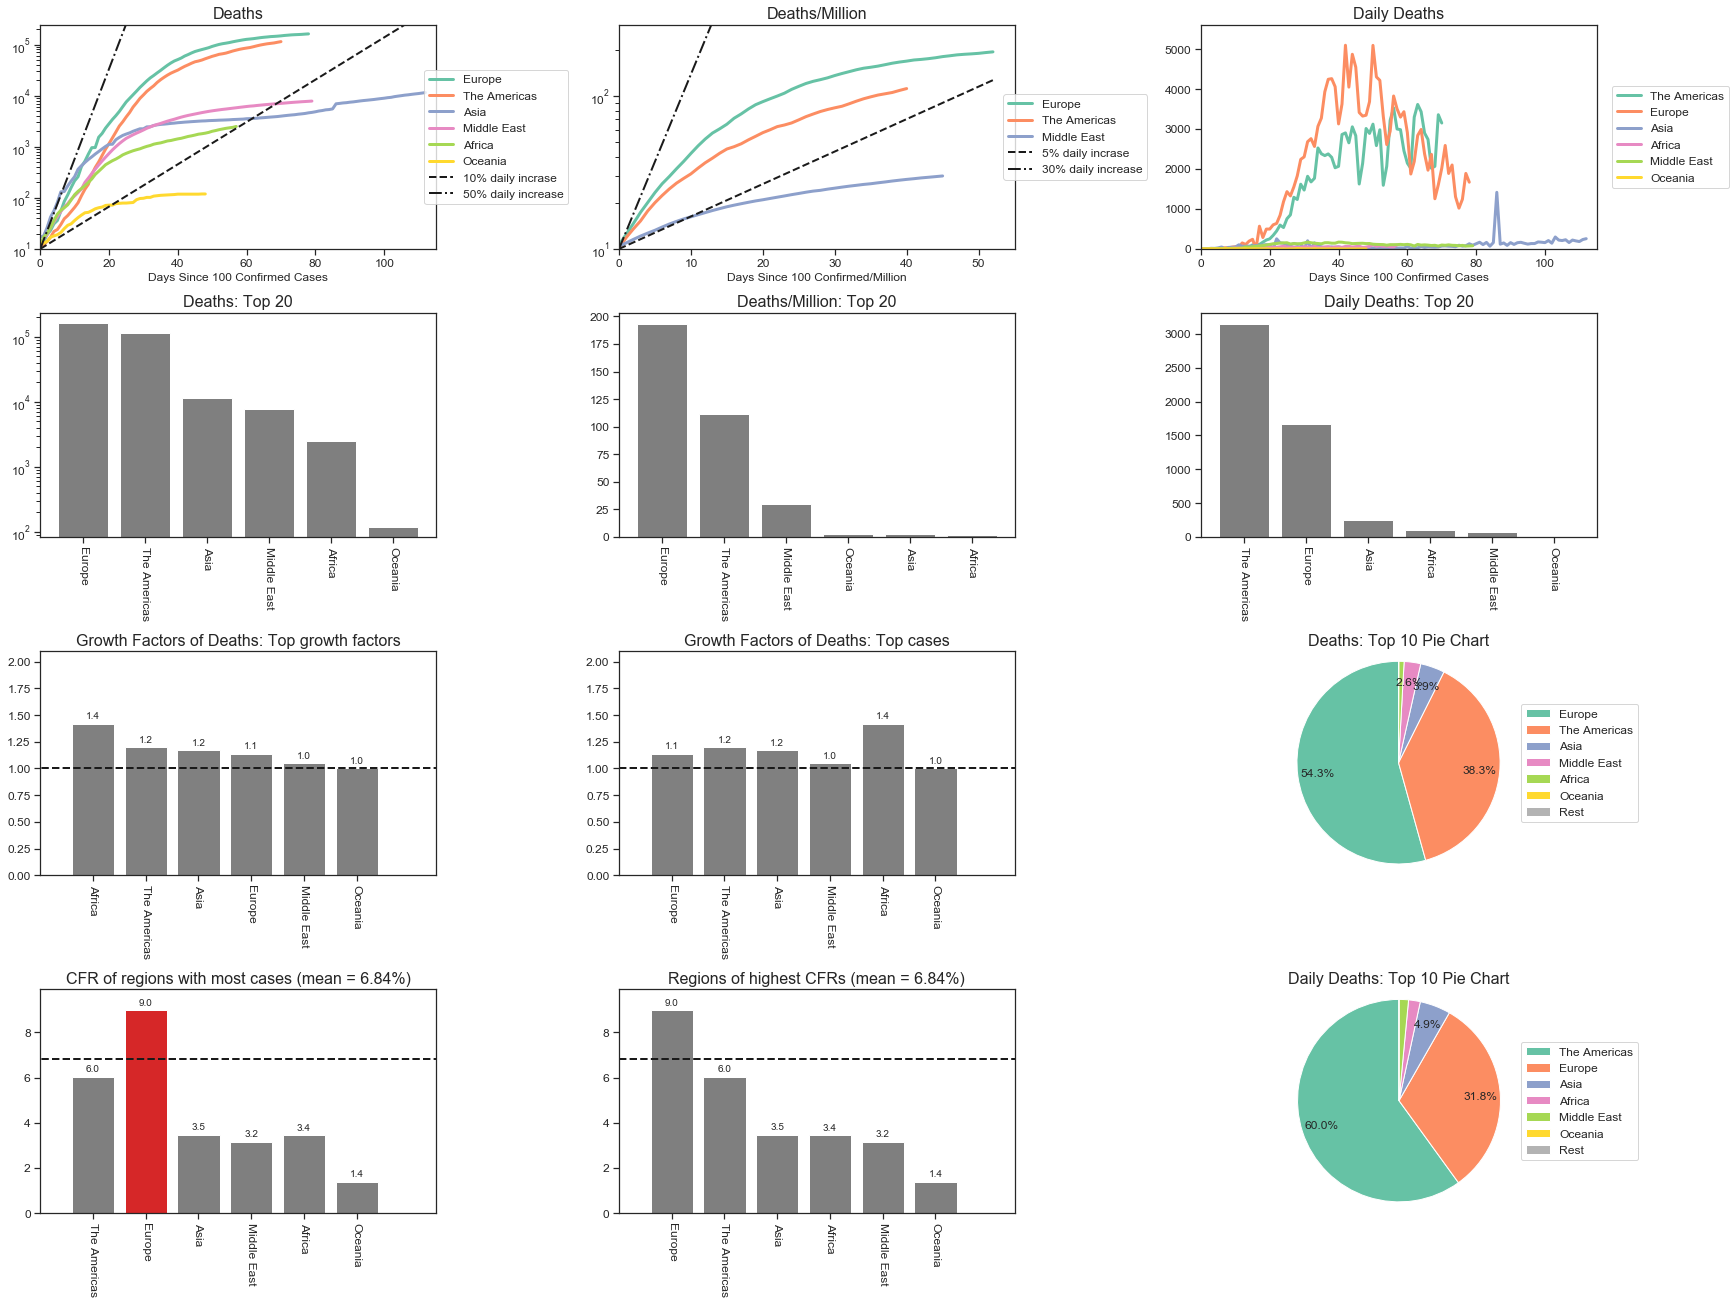

In [43]:
k_lines = [0.1, 0.5, 0.05, 0.3]
my_plot.plot_by_regions(df_confirmed_cont, df_deaths_cont, 
                        time_datetime, special = 'San Francisco', 
                        k_lines = k_lines, yscales = yscales, 
                        figsize = (24, 18), plot_type = 'Deaths')

In [44]:
""" World by countires """

' World by countires '

In [45]:
df_confirmed = df_global.groupby('Category').get_group('Confirmed').groupby('Country_Region').sum()[time_datetime]
df_deaths = df_global.groupby('Category').get_group('Deaths').groupby('Country_Region').sum()[time_datetime]
df_confirmed, df_deaths, = my_func.reshape_dataframe_v2(df_confirmed, df_deaths, df_world_population['Population'], time_datetime)

subplots: 0 1 2 3 4 5 6 7 8 9 

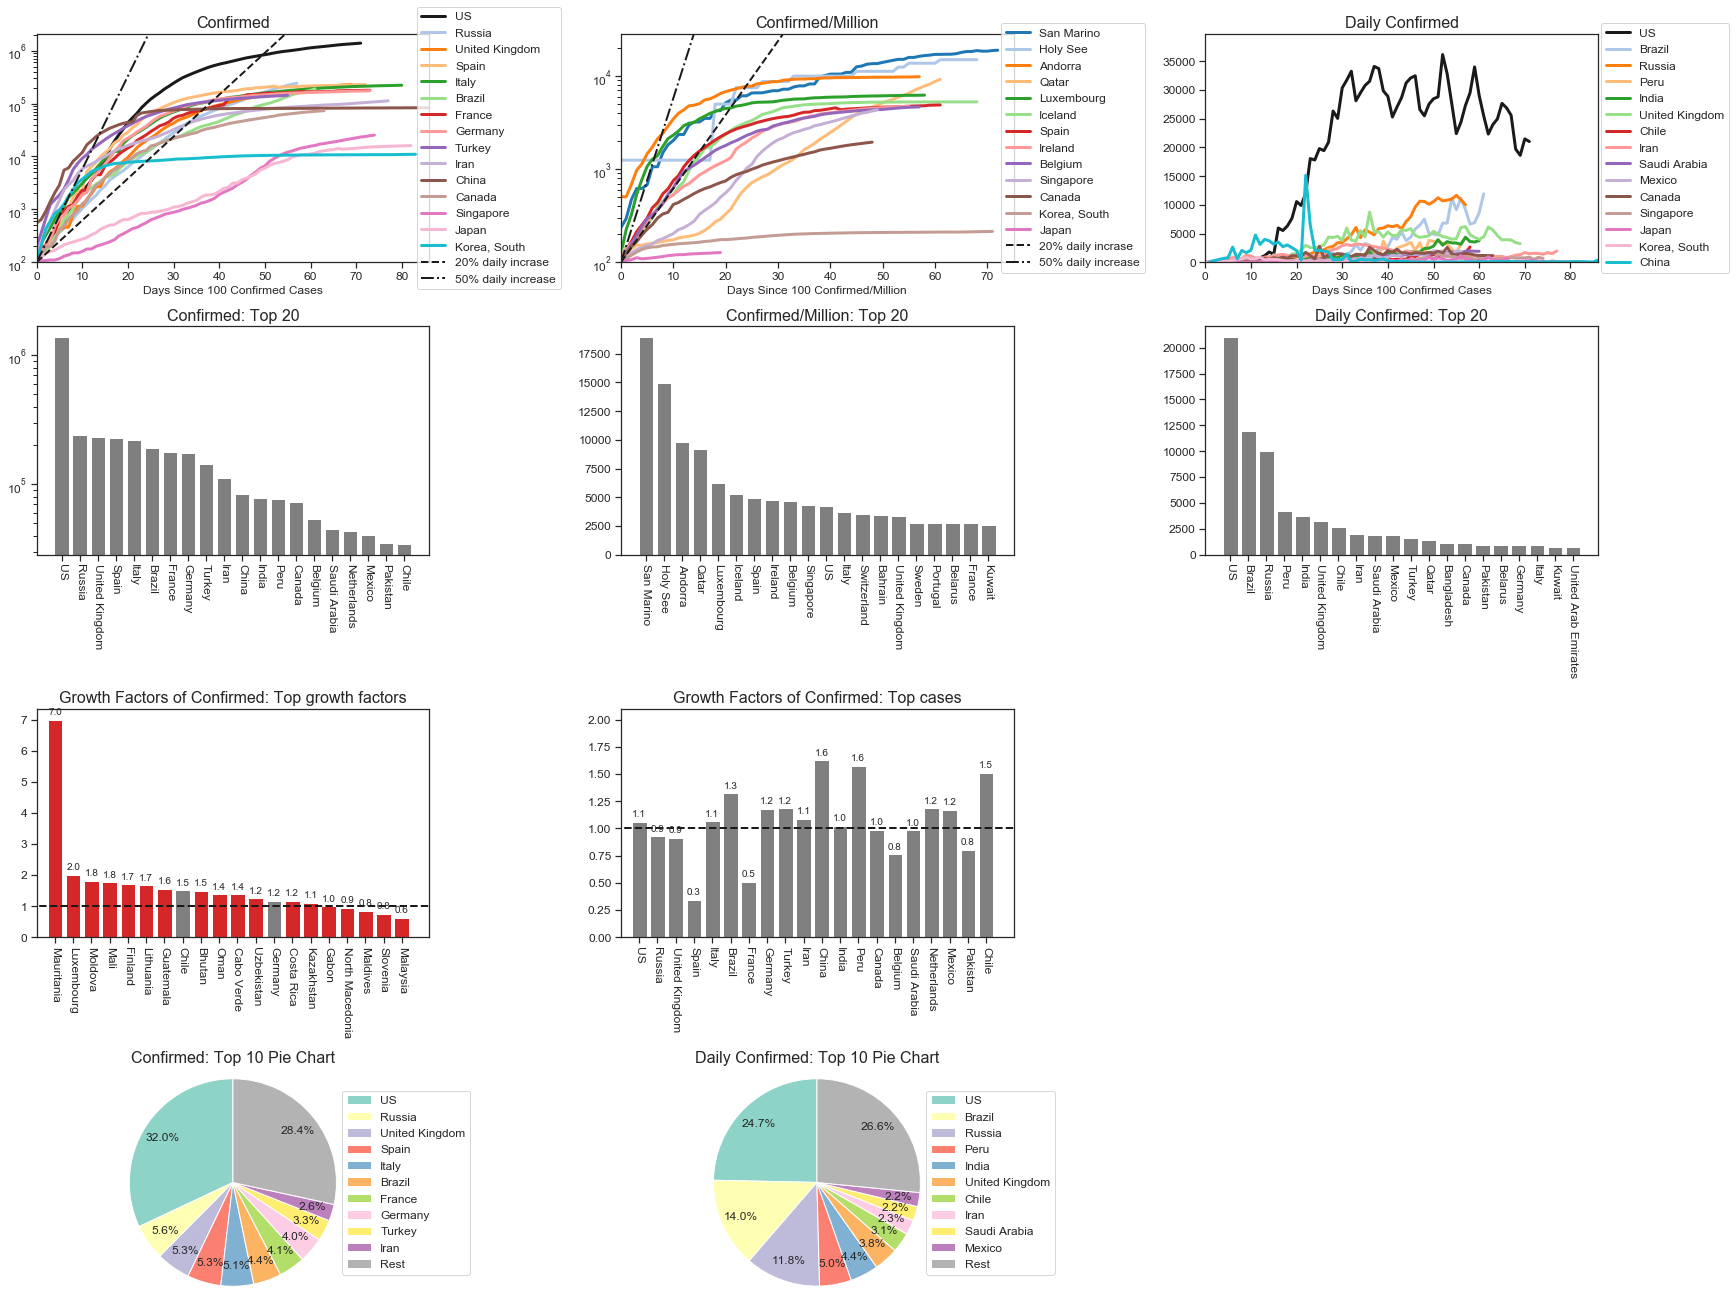

In [46]:
list_addins = ['China', 'Korea, South', 'Japan', 'Singapore', 'Canada']
yscales = ['log', 'log', 'linear', 'log', 'linear', 'linear', 'linear', 'linear']
k_lines = [0.2, 0.5, 0.2, 0.5]
my_plot.plot_by_regions(df_confirmed, df_deaths, 
                        time_datetime, special = 'US', list_addins = list_addins,
                        k_lines = k_lines, yscales = yscales, 
                        figsize = (24, 18), plot_type = 'Confirmed')

subplots: 0 1 2 3 4 5 6 7 8 9 10 11 

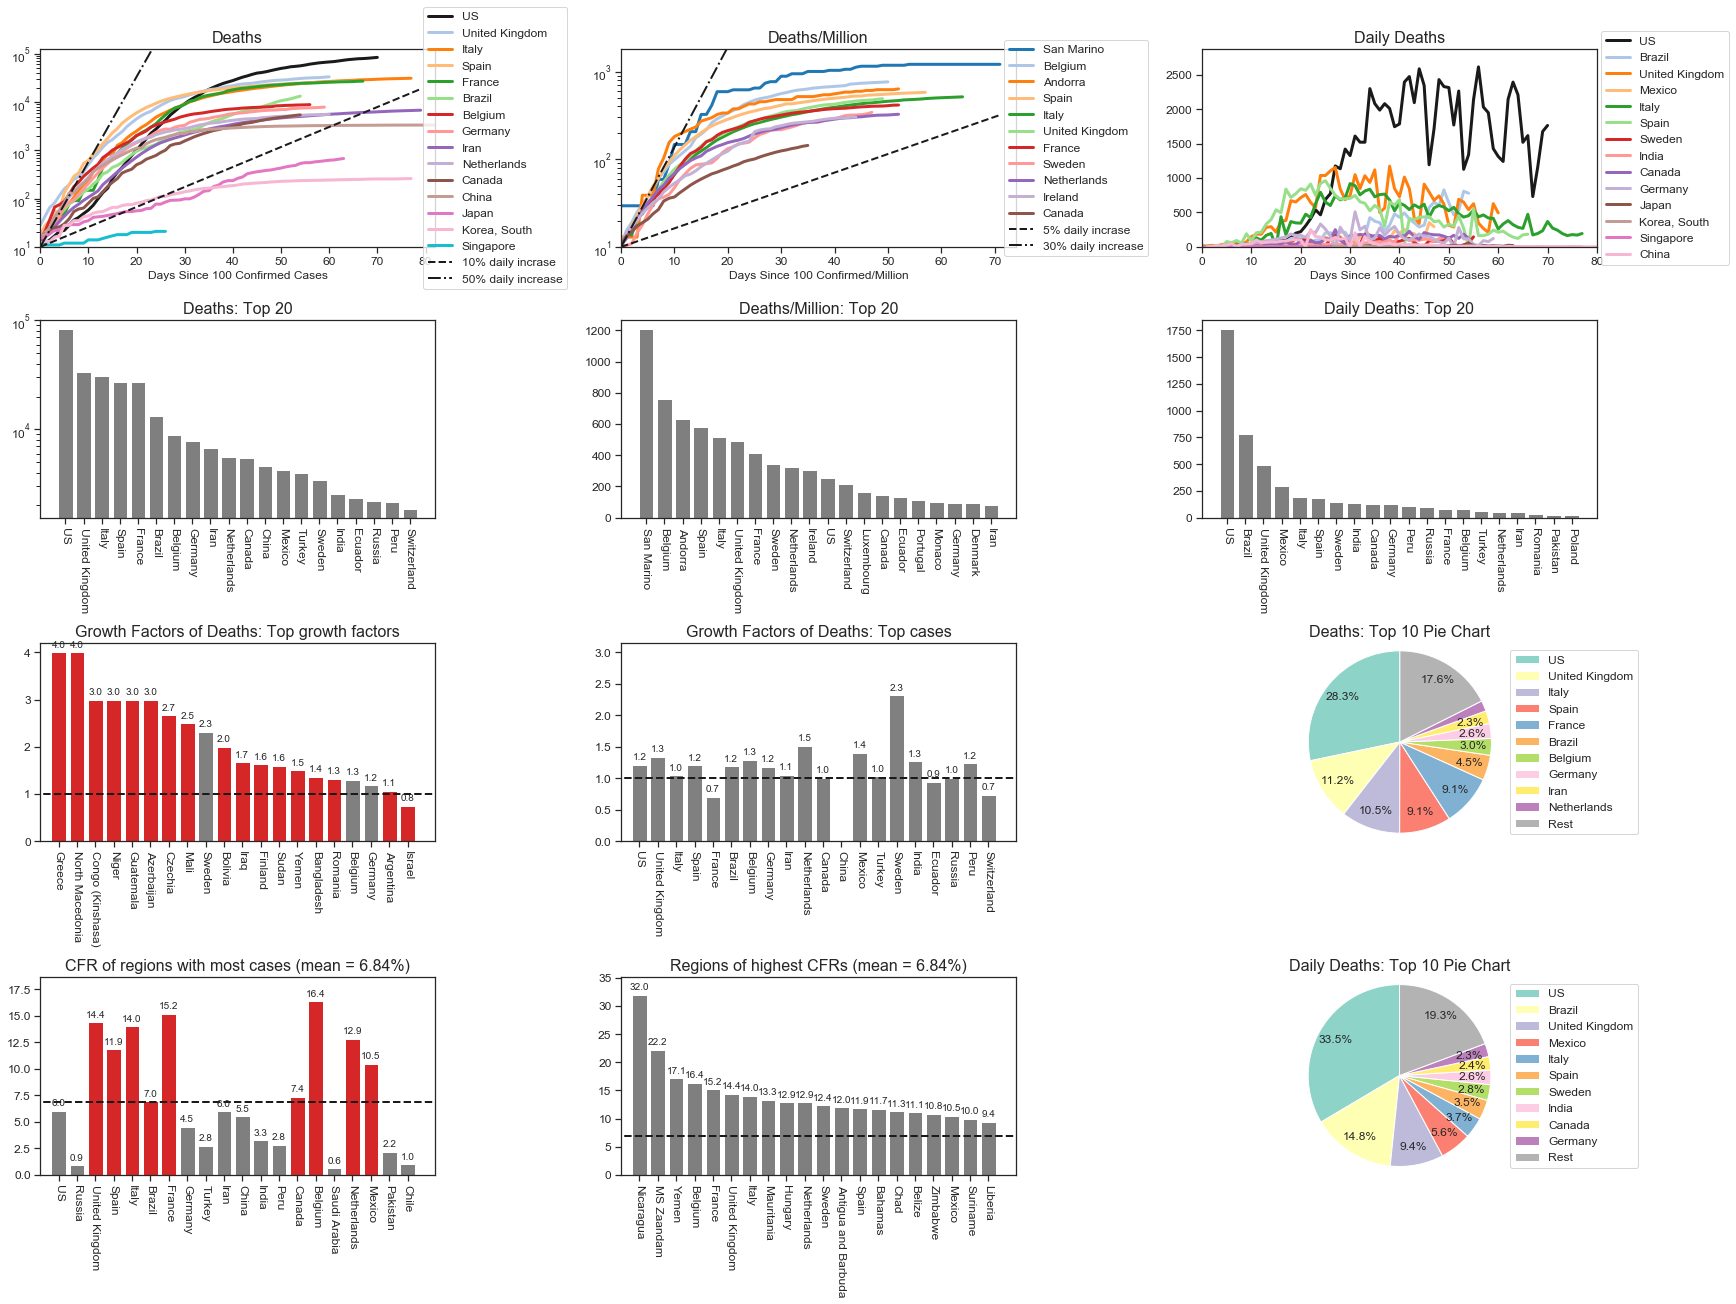

In [47]:
k_lines = [0.1, 0.5, 0.05, 0.3]
my_plot.plot_by_regions(df_confirmed, df_deaths, 
                        time_datetime, special = 'US', list_addins = list_addins,
                        k_lines = k_lines, yscales = yscales, 
                        figsize = (24, 18), plot_type = 'Deaths')

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-

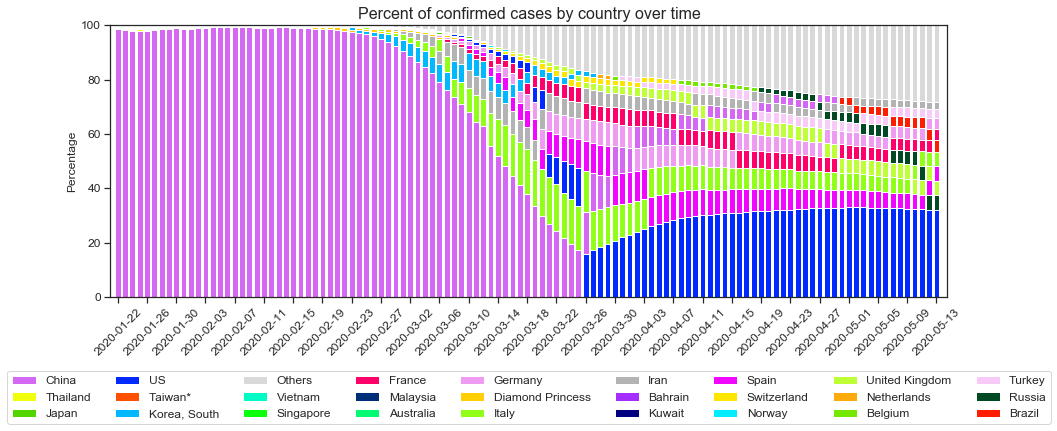

In [48]:
my_plot.plot_percentage_over_time(df_confirmed.loc[:,time_datetime], 10, 
                                  title = 'Percent of confirmed cases by country over time')


0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-

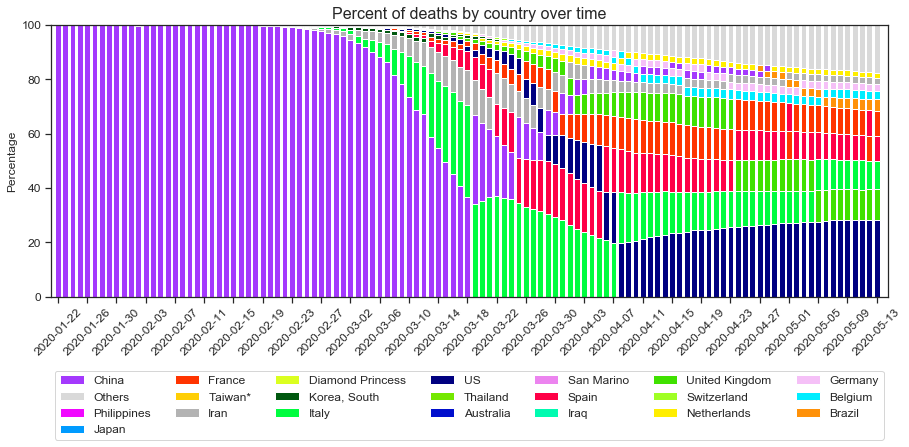

In [49]:
my_plot.plot_percentage_over_time(df_deaths.loc[:,time_datetime], 10, 
                                  title = 'Percent of deaths by country over time')

In [50]:
"""World by country: cases vs. population"""

'World by country: cases vs. population'

In [51]:
key_countries = list(df_ctry_today.sort_values(by = 'Total_Confirmed', ascending = False).index[:5])
key_countries += ['Korea, South', 'Singapore', 'Japan', 'Canada', 'India']
key_countries = list(set(key_countries))
my_plot.world_cases_vs_population(key_countries, df_ctry_today)

1-2-0-1-0-1-

ValueError: Image size of 900x71917 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x720 with 6 Axes>

In [52]:
""" China """

' China '

In [53]:
df_mc = df_global.groupby('Country_Region').get_group('China').groupby('Category').sum()
df_hb = df_global.groupby('Country_Region').get_group('China').groupby('Province_State').get_group('Hubei').groupby('Category').sum()
df_co = df_mc - df_hb
df_mc = my_func.reshape_dataframe(df_mc, time_datetime)
df_hb = my_func.reshape_dataframe(df_hb, time_datetime)
df_co = my_func.reshape_dataframe(df_co, time_datetime)

In [54]:
df_mc_confirmed = df_global.groupby('Country_Region').get_group('China').groupby('Category').get_group('Confirmed').groupby('Province_State').sum()[time_datetime]
df_mc_deaths = df_global.groupby('Country_Region').get_group('China').groupby('Category').get_group('Deaths').groupby('Province_State').sum()[time_datetime]
df_mc_confirmed, df_mc_deaths, = my_func.reshape_dataframe_v2(df_mc_confirmed, df_mc_deaths, df_china_population['Population'], time_datetime)

subplots: 0 1 2 3 4 5 6 7 8 9 

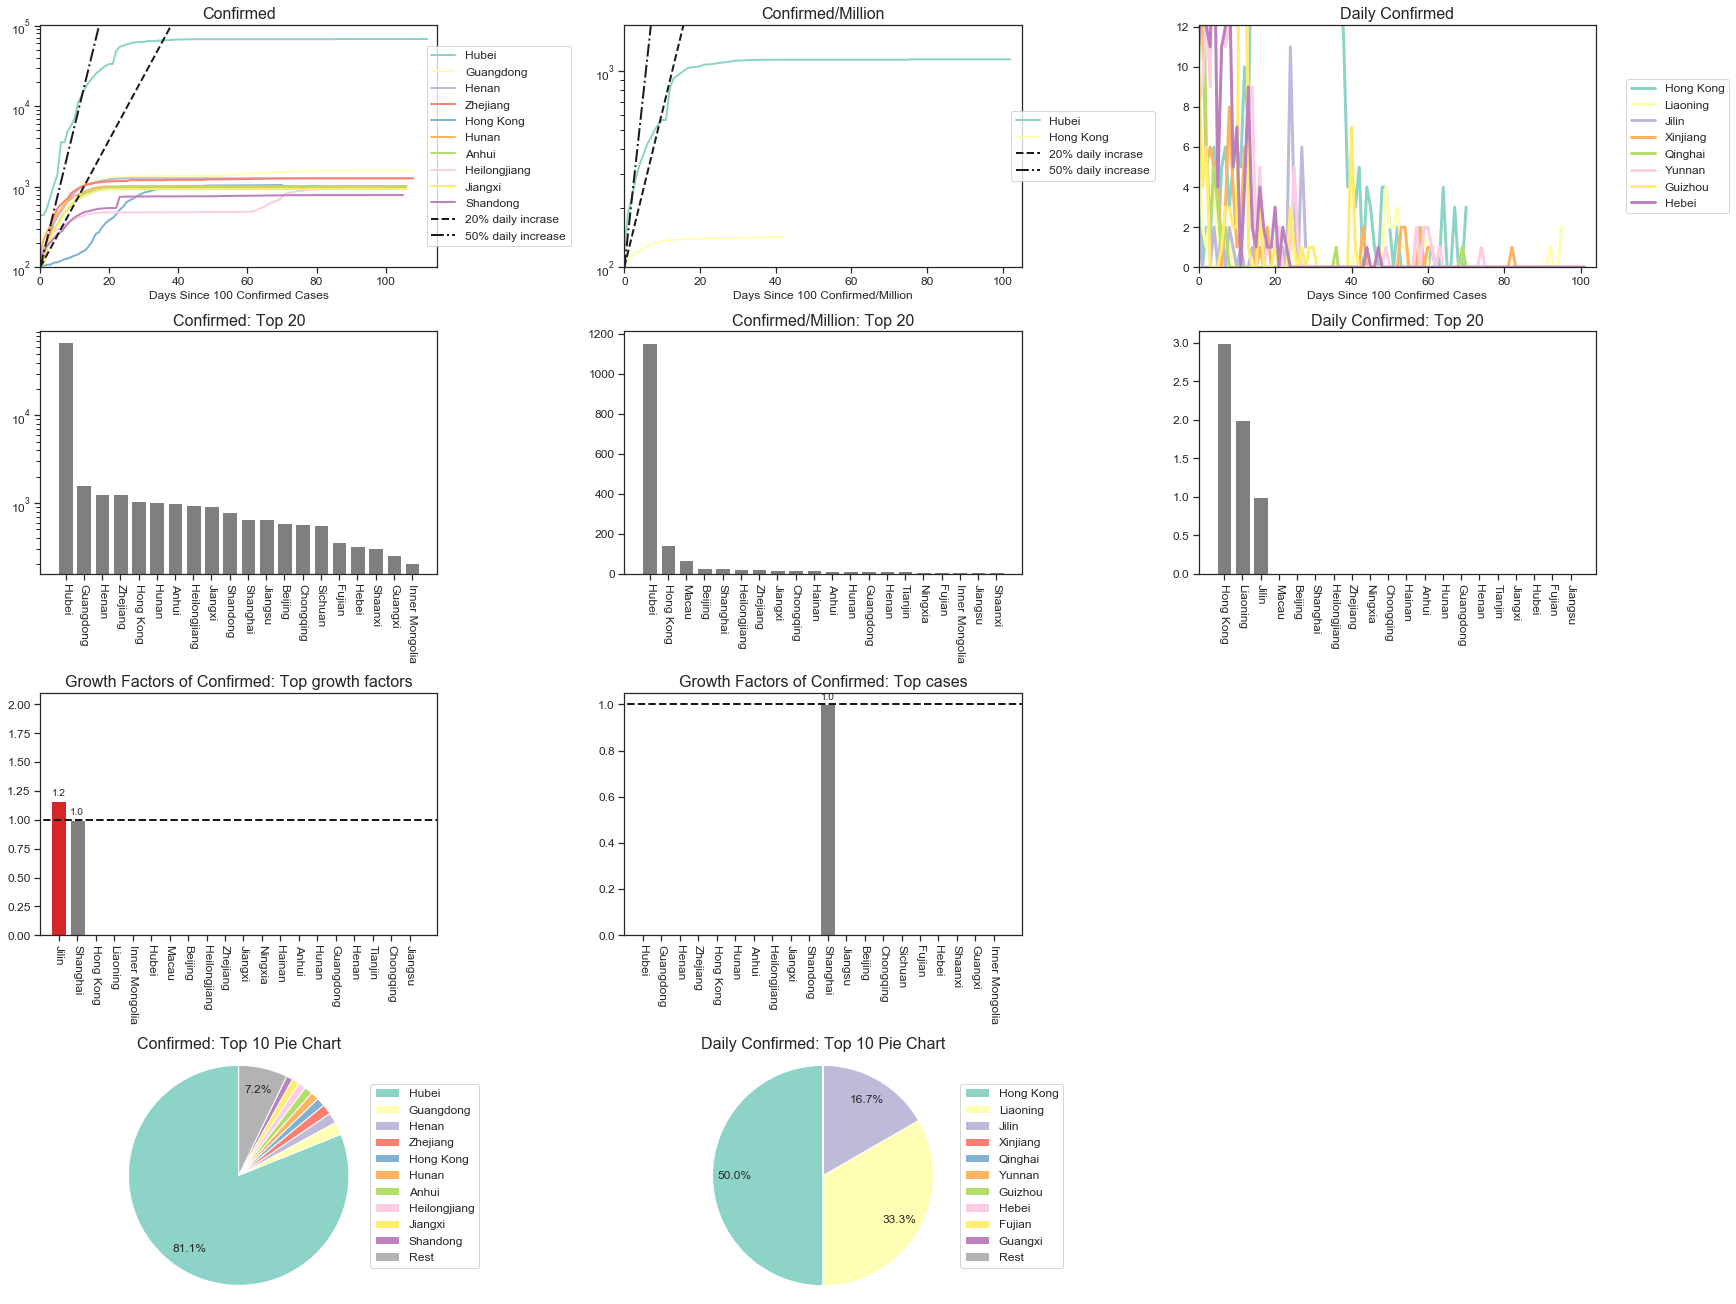

In [55]:
yscales = ['log', 'log', 'linear', 'log', 'linear', 'linear', 'linear', 'log']
k_lines = [0.2, 0.5, 0.2, 0.5]
my_plot.plot_by_regions(df_mc_confirmed, df_mc_deaths, 
                        time_datetime,
                        k_lines = k_lines, yscales = yscales, 
                        figsize = (24, 18), plot_type = 'Confirmed', show_recent = True)

subplots: 0 1 2 3 4 5 6 7 8 9 10 11 

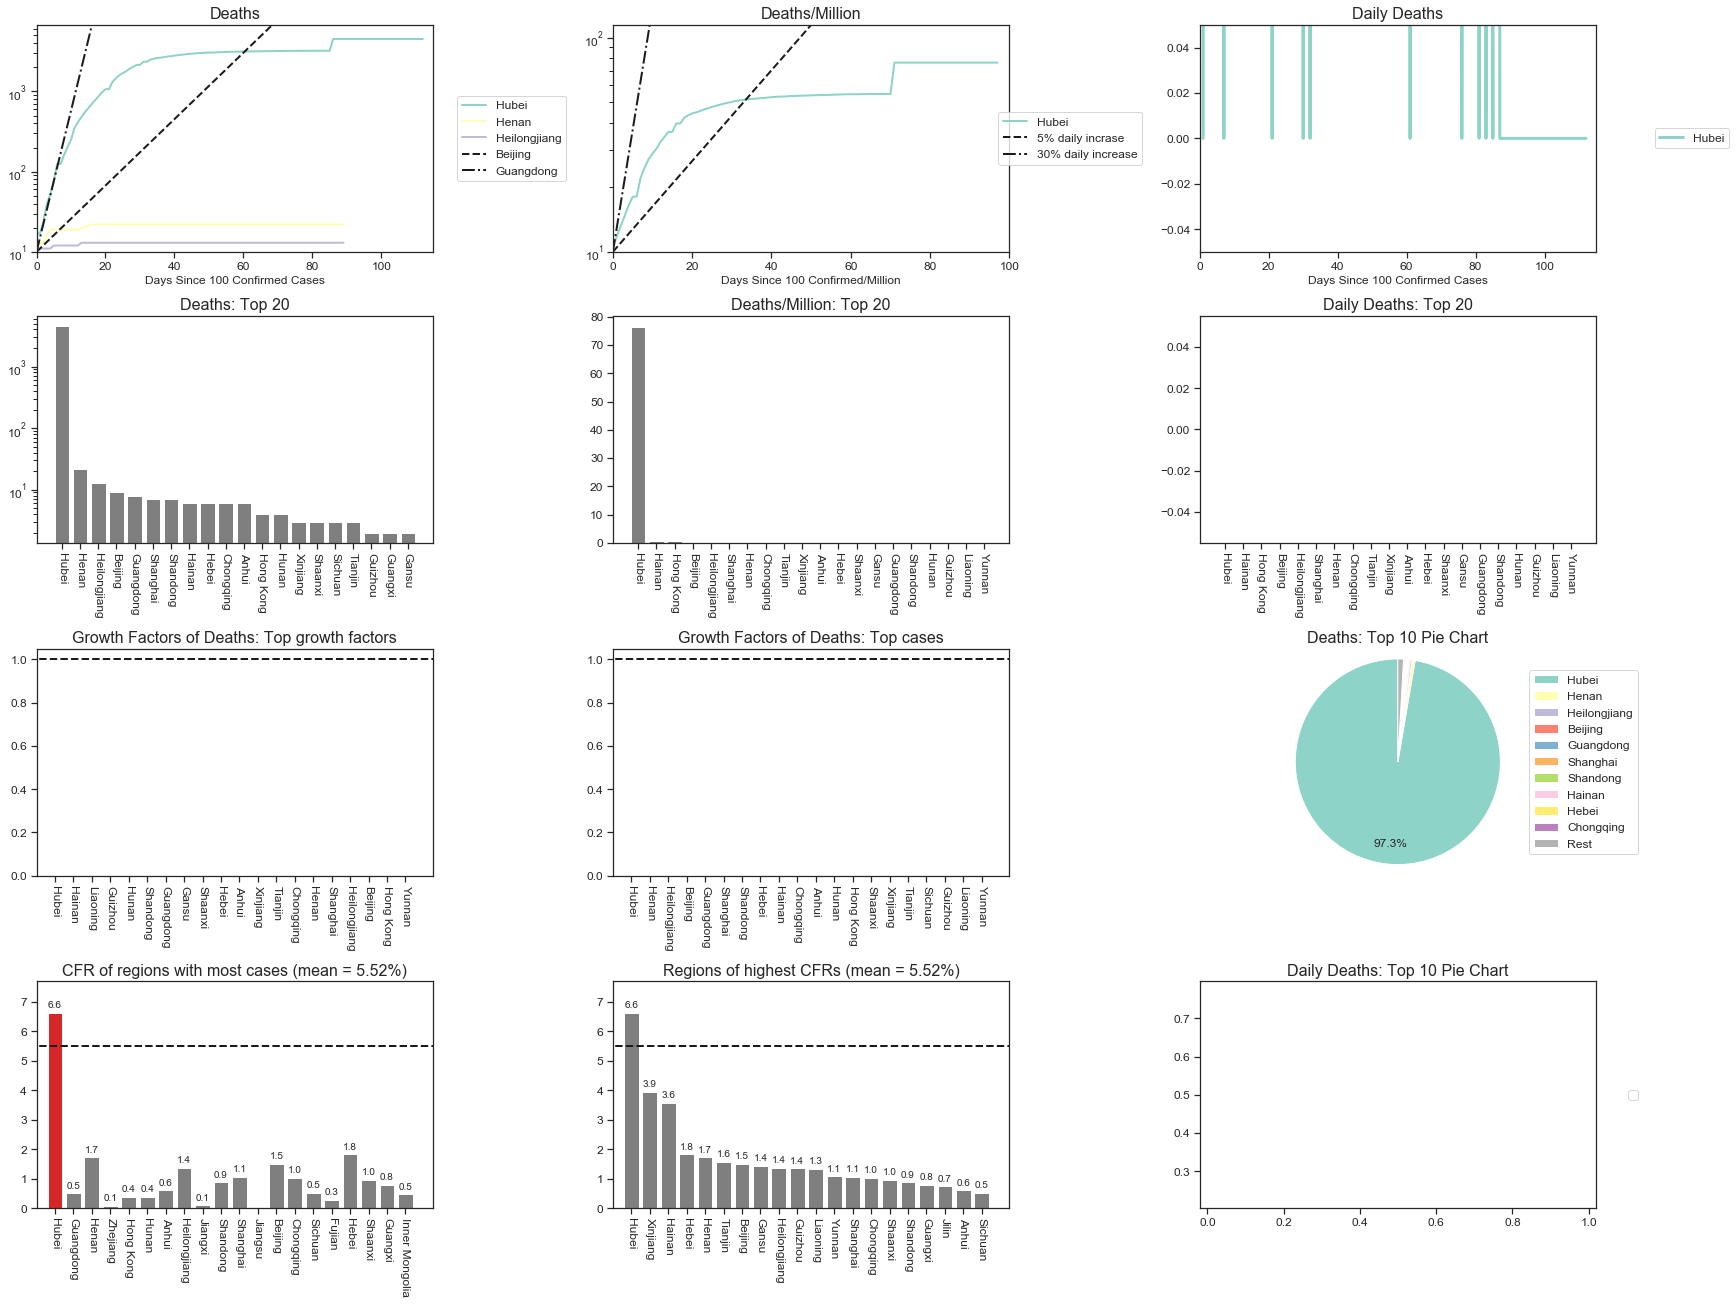

In [56]:
k_lines = [0.1, 0.5, 0.05, 0.3]
my_plot.plot_by_regions(df_mc_confirmed, df_mc_deaths, 
                        time_datetime,
                        k_lines = k_lines, yscales = yscales, 
                        figsize = (24, 18), plot_type = 'Deaths')

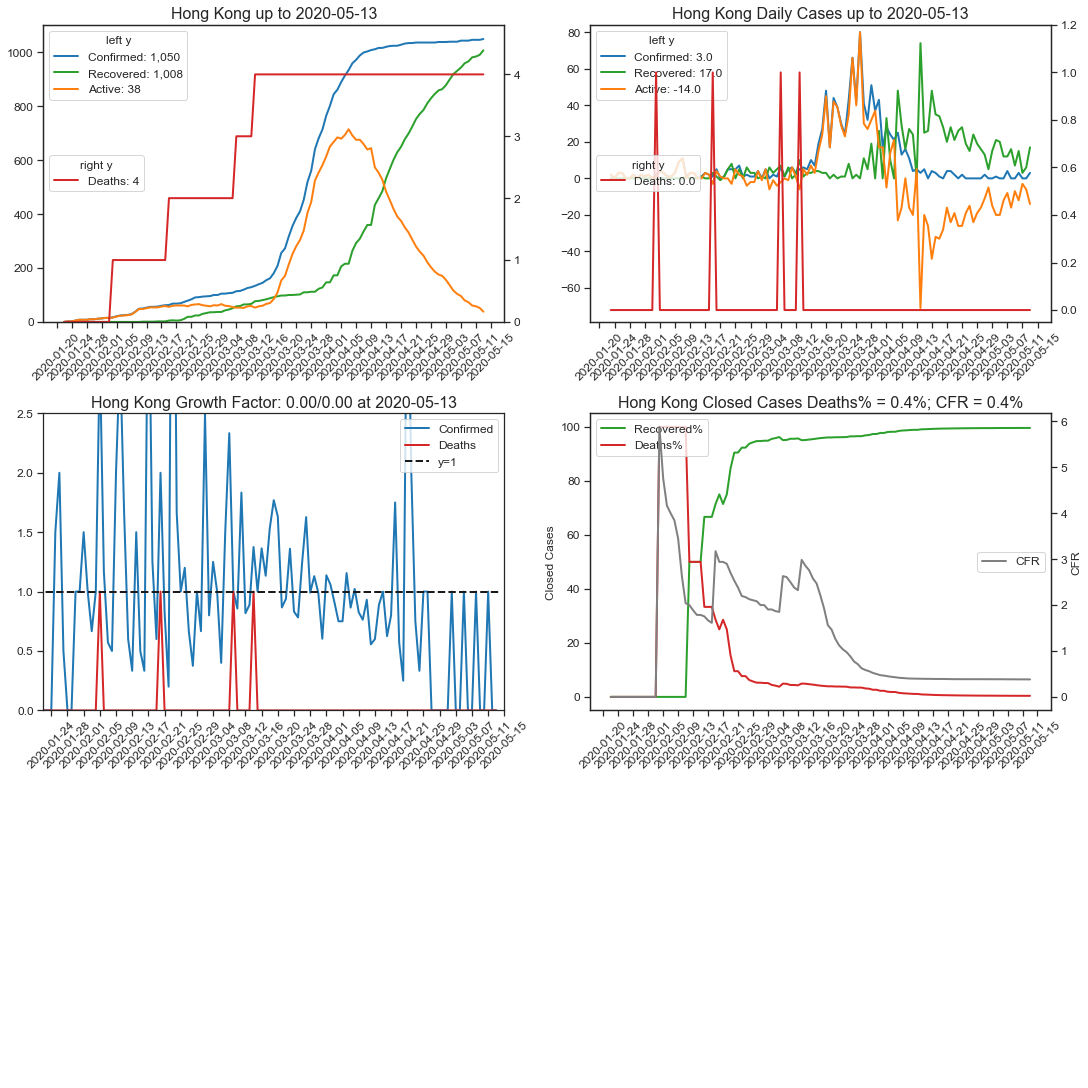

In [97]:
prov = 'Hong Kong'
df_prov = df_global.groupby('Country_Region').get_group('China').groupby('Province_State').get_group(prov).groupby('Category').sum().loc[:,time_datetime]
df_prov = my_func.reshape_dataframe(df_prov, time_datetime)
plotting_params = {
            'figsize':(15, 15),
            'time_series_cols' : ['Confirmed', 'Deaths', 'Recovered', 'Active'],
            'locator_param' : 4,
            'locator_param_future':12,
            'num_of_rols' : 3,
            'cat_color' : cat_color
        }
fitting_params = {
    'future':100,
    'p0_log' : (0.1, 1000, 0.01),
    'p0_exp':(0.1, 100),
    'bounds_c':((0,1000,0), (1, np.inf, 1)),
    'bounds_d':((0,1000,0), (1, np.inf, 1)),
    'death_to_confirmed':False,
    'thr_c':"rolling",
    'thr_d':'rolling',
    'method_c':'trf',
    'method_d':'trf',
    'plot_range':True,
}
my_plot.plot_region(df_prov, prov, plotting_params = plotting_params, 
                    is_fitting = False, fitting_params = fitting_params)

China w/o Hubei Confirmed cases: max daily increase at 2020-02-05, GF > 1 for today (2020-05-13). Prediction: r=0.12, K = 14,565~16,022, R^2 = 0.99 ~ 0.94; Predicted peak increase at 2020-02-06 ~ 2020-02-28, max will be reached at 2020-03-23 ~ 2020-06-08.
China w/o Hubei Deaths: max daily increase at 2020-02-14, new cases decreasing since 2020-03-14. Prediction: r=0.12, K = 122~125, R^2 = 0.99 ~ 0.99; peak increase at 2020-02-15 ~ 2020-02-27, CFR = 0.81%; max will be reached at 2020-03-14 ~ 2020-03-16.


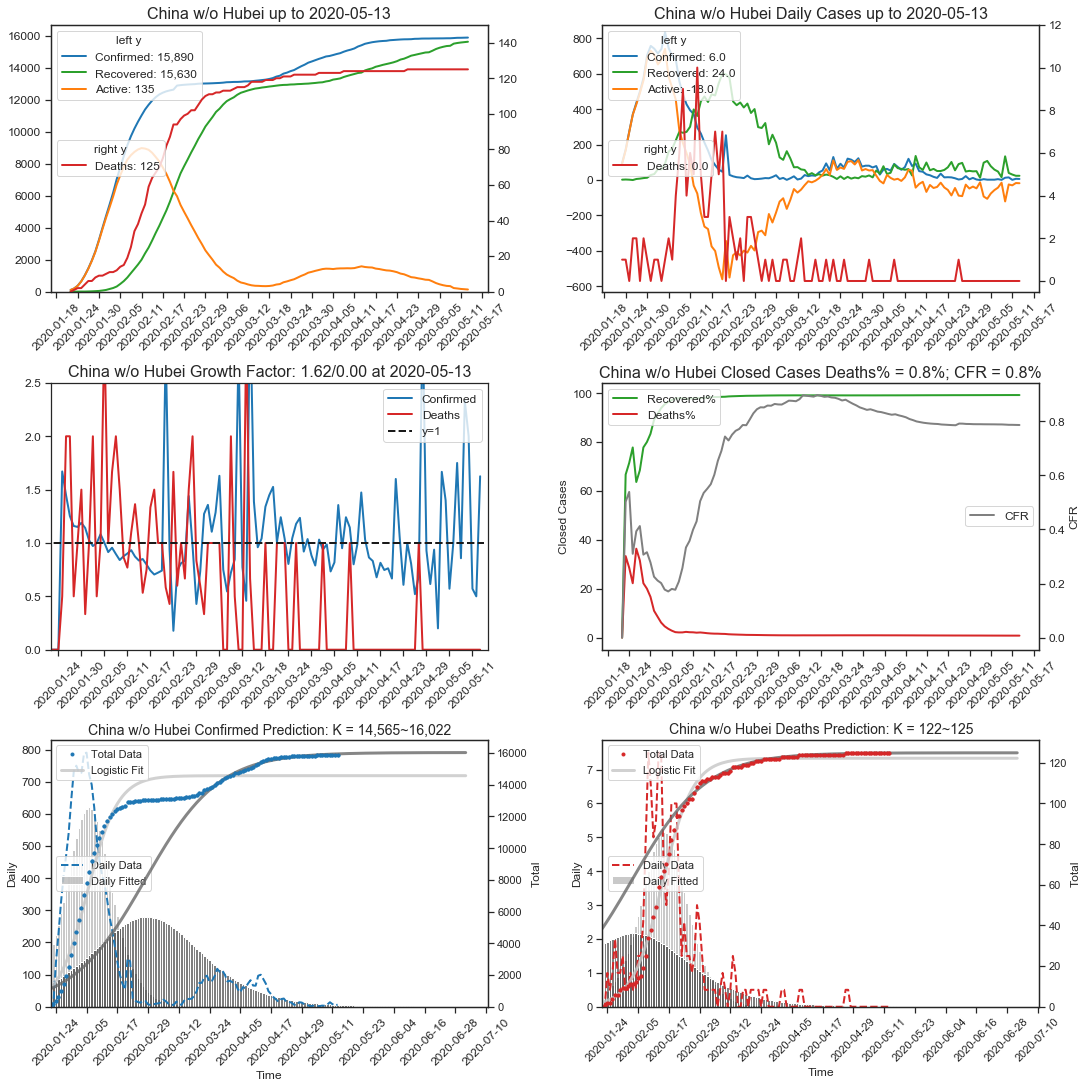

In [58]:
plotting_params = {
            'figsize':(15, 15),
            'time_series_cols' : ['Confirmed', 'Deaths', 'Recovered', 'Active'],
            'locator_param' : 6,
            'locator_param_future':12,
            'num_of_rols' : 3,
            'cat_color' : cat_color
        }
fitting_params = {
    'future':50,
    'p0_log' : (0.1, 1000, 0.01),
    'p0_exp':(0.1, 100),
    'bounds_c':((0,1000,0), (1, np.inf, 1)),
#     'bounds_d':((0,1000,0), (1, np.inf, 1)),
    'death_to_confirmed':False,
    'thr_c':"rolling",
    'thr_d':'rolling',
    'method_c':'trf',
    'method_d':'trf',
    'plot_range':True,
}
my_plot.plot_region(df_co, 'China w/o Hubei', plotting_params = plotting_params, show_recent = False,
                    is_fitting = True, fitting_params = fitting_params)

In [59]:
# plotting_params = {
#             'figsize':(16, 10),
#             'time_series_cols' : ['Confirmed', 'Deaths', 'Recovered', 'Active'],
#             'locator_param' : 4,
#             'num_of_rols' : 2,
#             'cat_color' : cat_color
# }
# my_plot.plot_china_prov(df_mc_confirmed, df_mc_deaths, df_hb, df_co, plotting_params = plotting_params)

In [60]:
""" Specific Country/Region"""

' Specific Country/Region'

In [61]:
df_confirmed.sort_values(by = time_datetime[-1], ascending = False, inplace = True)
df_confirmed.index[:30]

Index(['US', 'Russia', 'United Kingdom', 'Spain', 'Italy', 'Brazil', 'France',
       'Germany', 'Turkey', 'Iran', 'China', 'India', 'Peru', 'Canada',
       'Belgium', 'Saudi Arabia', 'Netherlands', 'Mexico', 'Pakistan', 'Chile',
       'Ecuador', 'Switzerland', 'Portugal', 'Sweden', 'Qatar', 'Belarus',
       'Singapore', 'Ireland', 'United Arab Emirates', 'Bangladesh'],
      dtype='object', name='Country_Region')

Brazil Confirmed cases: max daily increase at 2020-05-13, GF > 1 for today (2020-05-13). Prediction: r=0.09, K = 448,118~476,835, R^2 = 1.00 ~ 1.00; Predicted peak increase at 2020-07-01 ~ 2020-07-02, max will not be reached by 2020-08-21.
Brazil Deaths: max daily increase at 2020-05-13, GF > 1 for today (2020-05-13). Prediction: r=0.09, K = 25,239~42,658, R^2 = 1.00 ~ 1.00; peak increase at 2020-07-06 ~ 2020-07-16, CFR = 6.74%; max will be reached at 2020-09-26.


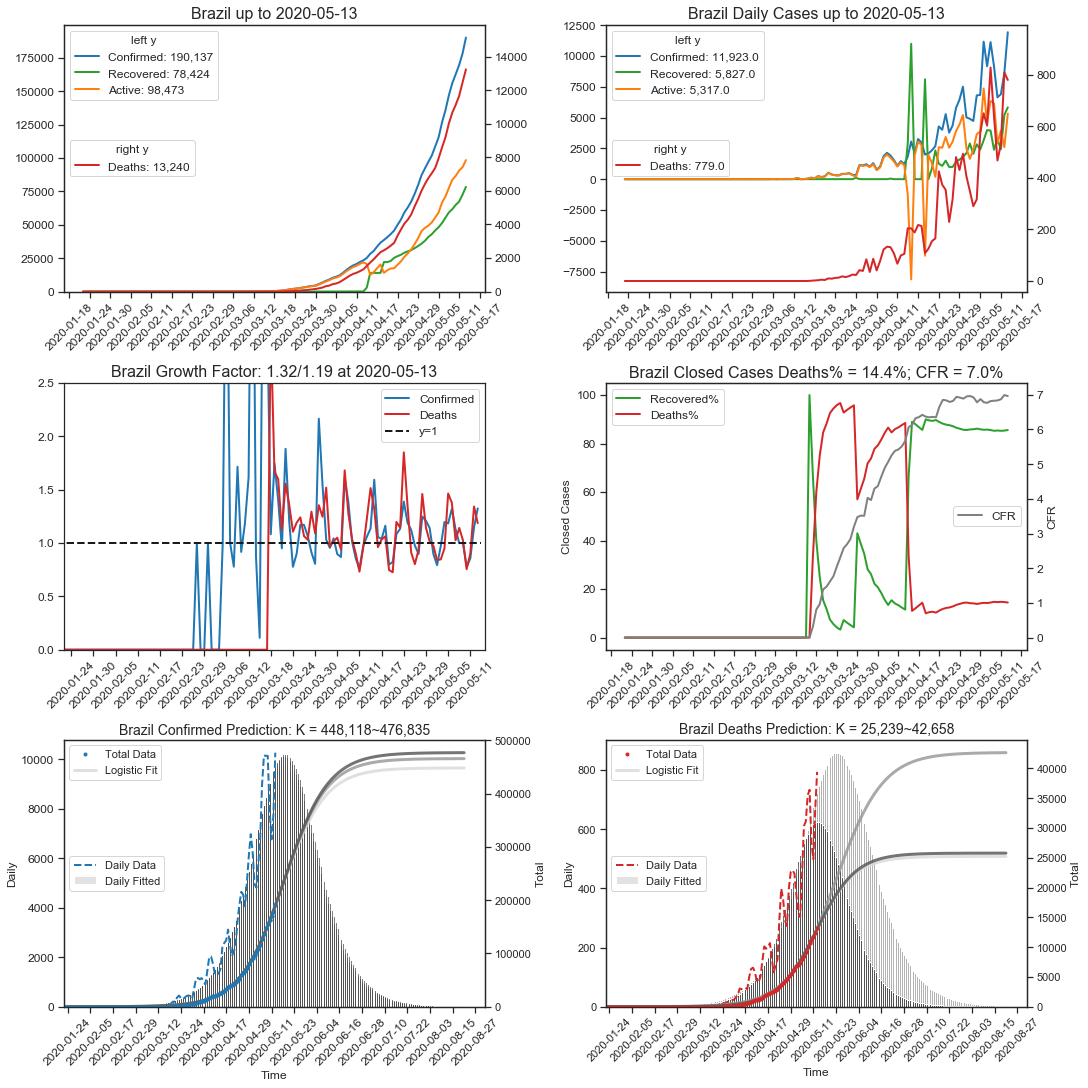

In [99]:
region = 'Brazil'
df_region = df_global.groupby('Country_Region').get_group(region).groupby('Category').sum()
df_region = my_func.reshape_dataframe(df_region, time_datetime)
plotting_params = {
            'figsize':(15, 15),
            'time_series_cols' : ['Confirmed', 'Deaths', 'Recovered', 'Active'],
            'locator_param' : 6,
            'locator_param_future':12,
            'num_of_rols' : 3,
            'cat_color' : cat_color
        }
fitting_params = {
    'future':100,
    'p0_log' : (0.1, 1000, 0.01),
    'p0_exp':(0.1, 100),
    'bounds_c':((0,1000,0), (1, np.inf, 1)),
    'bounds_d':((0,1000,0), (1, np.inf, 1)),
    'death_to_confirmed':False,
    'thr_c':"rolling",
    'thr_d':'rolling',
    'method_c':'trf',
    'method_d':'trf',
    'plot_range':True,
}
my_plot.plot_region(df_region, region, plotting_params = plotting_params, is_fitting = True, fitting_params = fitting_params)

In [63]:
### world bar graph

In [64]:
# df_confirmed.sort_values(by = time_datetime[-1], inplace = True, ascending=False)
# df_recovered.sort_values(by = time_datetime[-1], inplace = True, ascending=False)
# df_deaths.sort_values(by = time_datetime[-1], inplace = True, ascending=False)

In [65]:
# recovered = df_recovered.loc[:,time_str[-1]].to_numpy()
# deaths = df_deaths.loc[:,time_str[-1]].to_numpy()
# confirmed = df_confirmed.loc[:,time_str[-1]].to_numpy()
# x = np.arange(len(confirmed))

# fig, ax = plt.subplots(1,1,figsize = (40,6))
# rects = ax.bar(x, confirmed)
# plt.bar(x, deaths)
# plt.bar(x, recovered, bottom = deaths)

# plt.legend(['Confirmed', 'Recovered', 'Deaths'])
# plt.yscale('log')
# plt.ylim(bottom = 10**-0.1)
# plt.xlim([-1, len(x)])
# a = ax.set_xticks(x)
# a = ax.set_xticklabels(list(df_confirmed.index))
# a = plt.xticks(rotation=-90)
# a = plt.title(f'Total {len(df_confirmed.index)-4} Countries affected', fontsize = 18)
# autolabel(rects, ax, '{:.0f}')

In [66]:
"""World-wide testing"""

'World-wide testing'

In [67]:
# df_world_test_stats = pd.read_csv(os.path.join(path_time_series, 'world_test_stats.csv'))
# df_world_test_stats.set_index('Country_Region', inplace = True)

In [68]:
# df_ctry = df_time_series.groupby('Category').get_group('Confirmed').groupby('Country_Region').sum()
# df_china_prov = df_time_series.groupby('Category').get_group('Confirmed').groupby('Country_Region').get_group('China').groupby('Province_State').sum()

In [69]:
# for i, reg in enumerate(df_world_test_stats.index):
#     if('-' in reg):
#         ls = reg.split(' - ')
#         date = reformat_time_string(df_world_test_stats.loc[reg,'Date'])
#         df_world_test_stats.loc[reg,'Total_Cases'] = df_china_prov.loc[ls[0], date]
#     else:
#         if(reg == 'US'):
#             df_world_test_stats.loc[reg, 'Date'] = today
#             df_world_test_stats.loc[reg, 'Total_tests'] = df_us_tests.totalTestResults.sum()
#             df_world_test_stats.loc[reg, 'Total_Cases'] = df_confirmed.loc[reg, today]
#         else:
#             if(reg in df_ctry.index):
#                 date = reformat_time_string(df_world_test_stats.loc[reg,'Date'])
#                 df_world_test_stats.loc[reg, 'Total_Cases'] = df_ctry.loc[reg, date]
# df_world_test_stats.dropna(how='any', inplace = True)
# df_world_test_stats.loc[:,'Percent_Pos'] = df_world_test_stats.Total_Cases/df_world_test_stats.Total_tests*100
# df_world_test_stats['Population'] = 0
# overlap_index = intersection(list(df_world_population.index), list(df_world_test_stats.index))
# df_world_test_stats.loc[overlap_index,'Population'] = df_world_population.loc[overlap_index, 'Population']
# df_world_test_stats['Test_Per_Million'] = df_world_test_stats.Total_tests/(df_world_test_stats.Population/MILLION)
# df_world_test_stats['Pos_per_Million'] = df_world_test_stats.Total_tests/(df_world_test_stats.Population/MILLION)

In [70]:
# fig = plt.figure(figsize = (15, 10), constrained_layout=True, facecolor="1")
# gs = fig.add_gridspec(2,1)
# x = np.arange(len(df_world_test_stats.index))

# ###
# ax = fig.add_subplot(gs[0, :])
# df_world_test_stats.sort_values(by = 'Percent_Pos', inplace = True, ascending=False)
# sns.barplot(data = df_world_test_stats.reset_index(), x = 'Country_Region', y = 'Percent_Pos', color = 'grey')
# a = ax.set_xticks(x)
# a = ax.set_xticklabels(list(df_world_test_stats.index))
# a = plt.xticks(rotation=-90)
# _ = plt.title('Test positive rate')

# ax = fig.add_subplot(gs[1, :])
# df_world_test_stats.sort_values(by = 'Test_Per_Million', inplace = True, ascending=False)
# sns.barplot(data = df_world_test_stats.reset_index(), x = 'Country_Region', y = 'Test_Per_Million', color = 'grey')
# a = ax.set_xticks(x)
# a = ax.set_xticklabels(list(df_world_test_stats.index))
# a = plt.xticks(rotation=-90)
# _ = plt.title('Test performed per million population')



In [71]:
"""Playground"""

'Playground'

In [72]:
# df_world_population = pd.read_csv(os.path.join(path_time_series, 'world_population_stats.csv'), encoding = "ISO-8859-1", engine='python')
# df_world_population.loc[:, 'Population'] = df_world_population.Population.astype('float')
# df_world_population.set_index('Country_Region', inplace = True)

# df_ctry_today = pd.DataFrame(columns = ['Total_Confirmed', 'New_Confirmed', 'Total_Deaths', 'New_Deaths']+list(df_world_population.columns), 
#                              index = df_confirmed.index)
# df_ctry_today['Total_Confirmed'] = df_confirmed[today]
# df_ctry_today['New_Confirmed'] = df_confirmed['New_Today']
# indexis_intersect = intersection(list(df_world_population.index), list(df_confirmed.index))
# df_ctry_today.loc[:,list(df_world_population.columns)] = df_world_population.loc[indexis_intersect,:]
# df_ctry_today['Pos_per_Million'] = df_ctry_today.Total_Confirmed/(df_ctry_today.Population/MILLION)
# df_ctry_today['Total_Deaths'] = df_deaths[today]
# df_ctry_today['New_Deaths'] = df_deaths.loc[:,time_str[-1]] - df_deaths.loc[:,time_str[-2]]
# df_ctry_today.dropna(axis = 0, how = 'any', inplace = True)
# thr = 500
# cat = 'Confirmed_Cat'
# df_ctry_today.loc[df_ctry_today.Total_Confirmed>=thr, cat] = f'above_{thr}'
# df_ctry_today.loc[df_ctry_today.Total_Confirmed<thr, cat] = f'below_{thr}'
# thr = np.percentile(df_ctry_today.Population, 50)
# cat = 'Population_Cat'
# df_ctry_today.loc[df_ctry_today.Population>=thr, cat] = f'above_{thr/MILLION:.1f}M'
# df_ctry_today.loc[df_ctry_today.Population<thr, cat] = f'below_{thr/MILLION:.1f}M'

# # df_ctry_today['rank_Total'] = df_ctry_today['Total'].rank(ascending = False)
# # df_ctry_today['rank_New_Today'] = df_ctry_today['New_Today'].rank(ascending = False)
# # df_ctry_today['rank_Pos_per_Million'] = df_ctry_today['Pos_per_Million'].rank(ascending = False)
# # df_ctry_today['rank_Population'] = df_ctry_today.Population.rank()

In [73]:
# cat = 'Confirmed_Cat'
# df_plot = df_ctry_today[['Total_Confirmed', 'New_Confirmed', 'Pos_per_Million', 'Population']]
# df_plot = np.log10(df_plot)
# df_plot = df_plot.replace([np.inf, -np.inf], np.nan).dropna(how="any")
# df_plot[cat] = df_ctry_today[cat]
# plt.figure(figsize = (20, 20))
# sns.pairplot(df_plot, kind = 'reg', hue = cat)

In [74]:
# cat = 'Population_Cat'
# df_plot = df_ctry_today[['Total_Confirmed', 'New_Confirmed', 'Pos_per_Million', 'Population']]
# df_plot = np.log10(df_plot)
# df_plot = df_plot.replace([np.inf, -np.inf], np.nan).dropna(how="any")
# df_plot[cat] = df_ctry_today[cat]
# plt.figure(figsize = (20, 20))
# sns.pairplot(df_plot, kind = 'reg', hue = cat)

In [75]:
# cat_x = 'Total_Confirmed'
# cat_y = 'New_Confirmed'

# df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
# df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")

# fig, ax = plt.subplots(1,1, figsize = (10, 8))
# p1 = sns.regplot(data = df_fit, 
#                  x = cat_x, y = cat_y, ax = ax)



# X = np.array([df_fit[cat_x]]).transpose()
# y = df_fit[cat_y].to_numpy()
# reg = LinearRegression().fit(X, y)
# y_predicted = reg.predict(X)
# residuals = (y-y_predicted)
# df_fit.loc[:,'Residuals'] = residuals
# countries = []
# countries += list(df_fit.sort_values(by = 'Residuals').index[:5])
# countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

# for ctry in countries:
#     pos = [df_fit.loc[ctry, cat_x], 
#               df_fit.loc[ctry, cat_y]]
#     p1.text(pos[0]+0.01, pos[1] +0.01, ctry, 
#             horizontalalignment='left', size='medium', 
#             color='black',weight='normal')


In [76]:
# df_ctry_today.columns

In [77]:
# cat_x = 'Total_Confirmed'
# cat_y = 'Total_Deaths'

# fig = plt.figure(figsize = (15, 5), constrained_layout=True, facecolor="1")
# gs = fig.add_gridspec(1,3)

# ax = fig.add_subplot(gs[0,0])
# df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
# df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
# p1 = sns.regplot(data = df_fit, 
#             x = cat_x, y = cat_y, ax = ax)

# ax = fig.add_subplot(gs[0,1])
# cat = 'Confirmed_Cat'
# cats = list(set(df_ctry_today[cat]))

# df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
# df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
# df_fit[cat] = df_ctry_today[cat]
# for icat in cats:
#     p1 = sns.regplot(data = df_fit[df_fit[cat] == icat], 
#                 x = cat_x, y = cat_y, ax = ax)

# ax = fig.add_subplot(gs[0,2])
# cat = 'Population_Cat'
# cats = list(set(df_ctry_today[cat]))

# df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
# df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
# df_fit[cat] = df_ctry_today[cat]
# for icat in cats:
#     p1 = sns.regplot(data = df_fit[df_fit[cat] == icat], 
#                 x = cat_x, y = cat_y, ax = ax)




# # X = np.array([df_fit[cat_x]]).transpose()
# # y = df_fit[cat_y].to_numpy()
# # reg = LinearRegression().fit(X, y)
# # y_predicted = reg.predict(X)
# # residuals = (y-y_predicted)
# # df_fit.loc[:,'Residuals'] = residuals
# # countries = []
# # countries += list(df_fit.sort_values(by = 'Residuals').index[:5])
# # countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

# # for ctry in countries:
# #     pos = [df_fit.loc[ctry, cat_x], 
# #               df_fit.loc[ctry, cat_y]]
# #     p1.text(pos[0]+0.01, pos[1] +0.01, ctry, 
# #             horizontalalignment='left', size='medium', 
# #             color='black',weight='normal')


In [78]:
# cat_x = 'Total_Confirmed'
# cat_y = 'Pos_per_Million'

# fig = plt.figure(figsize = (15, 5), constrained_layout=True, facecolor="1")
# gs = fig.add_gridspec(1,3)

# ax = fig.add_subplot(gs[0,0])
# df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
# df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
# p1 = sns.regplot(data = df_fit, 
#             x = cat_x, y = cat_y, ax = ax)

# ax = fig.add_subplot(gs[0,1])
# cat = 'Confirmed_Cat'
# cats = list(set(df_ctry_today[cat]))

# df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
# df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
# df_fit[cat] = df_ctry_today[cat]
# for icat in cats:
#     p1 = sns.regplot(data = df_fit[df_fit[cat] == icat], 
#                 x = cat_x, y = cat_y, ax = ax)
# ax.legend(cats)

# ax = fig.add_subplot(gs[0,2])
# cat = 'Population_Cat'
# cats = list(set(df_ctry_today[cat]))

# df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
# df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
# df_fit[cat] = df_ctry_today[cat]
# for icat in cats:
#     p1 = sns.regplot(data = df_fit[df_fit[cat] == icat], 
#                 x = cat_x, y = cat_y, ax = ax)
# ax.legend(cats)


In [79]:
# cat_x = 'Total_Confirmed'
# cat_y = 'Pos_per_Million'
# df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
# df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")

# fig, ax = plt.subplots(1,1, figsize = (10, 8))
# # ax.set(xscale = 'log', yscale = 'log')
# # x_lim = [np.min(df_ctry_today[cat_x]), np.max(df_ctry_today[cat_x])]
# # y_lim = [np.min(df_ctry_today[cat_y]), np.max(df_ctry_today[cat_y])]
# p1 = sns.regplot(data = df_fit, 
#                 x = cat_x, y = cat_y, ax = ax)


# X = np.array([df_fit[cat_x]]).transpose()
# y = df_fit[cat_y].to_numpy()
# reg = LinearRegression().fit(X, y)
# y_predicted = reg.predict(X)
# residuals = (y-y_predicted)
# df_fit.loc[:,'Residuals'] = residuals
# countries = []
# countries += list(df_fit.sort_values(by = 'Residuals').index[:5])
# countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

# for ctry in countries:
#     pos = [df_fit.loc[ctry, cat_x], 
#               df_fit.loc[ctry, cat_y]]
#     p1.text(pos[0]+0.1, pos[1] +0.1, ctry, 
#             horizontalalignment='left', size='medium', 
#             color='black',weight='normal')


In [80]:
# cat_x = 'Population'
# cat_y = 'Pos_per_Million'

# df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])

# fig, ax = plt.subplots(1,1, figsize = (10, 8))
# # ax.set(xscale = 'log', yscale = 'log')
# x_lim = [np.min(df_ctry_today[cat_x]), np.max(df_ctry_today[cat_x])]
# y_lim = [np.min(df_ctry_today[cat_y]), np.max(df_ctry_today[cat_y])]
# p1 = sns.regplot(data = df_fit, 
#                 x = cat_x, y = cat_y, ax = ax, robust = False)

# X = np.array([df_fit[cat_x]]).transpose()
# y = df_fit[cat_y].to_numpy()
# reg = LinearRegression().fit(X, y)
# y_predicted = reg.predict(X)
# residuals = (y-y_predicted)
# df_fit.loc[:,'Residuals'] = np.abs(residuals)
# countries = []
# countries += list(df_fit.sort_values(by = 'Residuals').index[-10:])
# if 'China' not in countries:
#     countries.append('China')
# # countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

# for ctry in countries:
#     pos = [df_fit.loc[ctry, cat_x], 
#               df_fit.loc[ctry, cat_y]]
#     p1.text(pos[0]+0.1, pos[1] +0.1, ctry, 
#             horizontalalignment='left', size='medium', 
#             color='black',weight='normal')

# # y_lim = [0, 2500]
# # ax.set_ylim(y_lim)
# # ax.set_xlim(x_lim)

# # ax.set_xscale('log')
# # ax.set_yscale('log')

In [81]:
# country_list = df_ctry_today.sort_values(by = 'Total', ascending = False, inplace = False).index[0:50]


In [82]:
# cat_x = 'Population'
# cat_y = 'Pos_per_Million'

# df_fit = np.log10(df_ctry_today.loc[country_list, [cat_x, cat_y]])

# fig, ax = plt.subplots(1,1, figsize = (10, 8))
# # ax.set(xscale = 'log', yscale = 'log')
# # x_lim = [np.min(df_ctry_today[cat_x]), np.max(df_ctry_today[cat_x])]
# # y_lim = [np.min(df_ctry_today[cat_y]), np.max(df_ctry_today[cat_y])]
# p1 = sns.regplot(data = df_fit, 
#                 x = cat_x, y = cat_y, ax = ax)

# X = np.array([df_fit[cat_x]]).transpose()
# y = df_fit[cat_y].to_numpy()
# reg = LinearRegression().fit(X, y)
# y_predicted = reg.predict(X)
# residuals = (y-y_predicted)
# df_fit.loc[:,'Residuals'] = np.abs(residuals)
# countries = []
# countries += list(df_fit.sort_values(by = 'Residuals').index[-10:])

# if 'China' not in countries:
#     countries.append('China')
# # countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

# for ctry in countries:
#     pos = [df_fit.loc[ctry, cat_x], 
#               df_fit.loc[ctry, cat_y]]
#     p1.text(pos[0]+0.1, pos[1] +0.1, ctry, 
#             horizontalalignment='left', size='medium', 
#             color='black',weight='normal')

# # y_lim = [0, 2500]a
# # ax.set_ylim(y_lim)
# # ax.set_xlim(x_lim)

# # ax.set_xscale('log')
# # ax.set_yscale('log')

In [83]:
# cat_x = 'Total'
# cat_y = 'Pos_per_Million'

# df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])

# fig, ax = plt.subplots(1,1, figsize = (10, 8))
# # ax.set(xscale = 'log', yscale = 'log')
# x_lim = [np.min(df_ctry_today[cat_x]), np.max(df_ctry_today[cat_x])]
# y_lim = [np.min(df_ctry_today[cat_y]), np.max(df_ctry_today[cat_y])]
# p1 = sns.regplot(data = df_fit, 
#                 x = cat_x, y = cat_y, ax = ax, robust = False)

# X = np.array([df_fit[cat_x]]).transpose()
# y = df_fit[cat_y].to_numpy()
# reg = LinearRegression().fit(X, y)
# y_predicted = reg.predict(X)
# residuals = (y-y_predicted)
# df_fit.loc[:,'Residuals'] = np.abs(residuals)
# countries = []
# countries += list(df_fit.sort_values(by = 'Residuals').index[-10:])
# if 'China' not in countries:
#     countries.append('China')
# # countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

# for ctry in countries:
#     pos = [df_fit.loc[ctry, cat_x], 
#               df_fit.loc[ctry, cat_y]]
#     p1.text(pos[0]+0.1, pos[1] +0.1, ctry, 
#             horizontalalignment='left', size='medium', 
#             color='black',weight='normal')

# # y_lim = [0, 2500]
# # ax.set_ylim(y_lim)
# # ax.set_xlim(x_lim)

# # ax.set_xscale('log')
# # ax.set_yscale('log')

In [84]:
# cat_x = 'Total'
# cat_y = 'Pos_per_Million'

# df_fit = np.log10(df_ctry_today.loc[country_list, [cat_x, cat_y]])

# fig, ax = plt.subplots(1,1, figsize = (10, 8))
# # ax.set(xscale = 'log', yscale = 'log')
# # x_lim = [np.min(df_ctry_today[cat_x]), np.max(df_ctry_today[cat_x])]
# # y_lim = [np.min(df_ctry_today[cat_y]), np.max(df_ctry_today[cat_y])]
# p1 = sns.regplot(data = df_fit, 
#                 x = cat_x, y = cat_y, ax = ax)

# X = np.array([df_fit[cat_x]]).transpose()
# y = df_fit[cat_y].to_numpy()
# reg = LinearRegression().fit(X, y)
# y_predicted = reg.predict(X)
# residuals = (y-y_predicted)
# df_fit.loc[:,'Residuals'] = np.abs(residuals)
# countries = []
# countries += list(df_fit.sort_values(by = 'Residuals').index[-10:])

# if 'China' not in countries:
#     countries.append('China')
# # countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

# for ctry in countries:
#     pos = [df_fit.loc[ctry, cat_x], 
#               df_fit.loc[ctry, cat_y]]
#     p1.text(pos[0]+0.05, pos[1] +0.05, ctry, 
#             horizontalalignment='left', size='medium', 
#             color='black',weight='normal')

# # y_lim = [0, 2500]a
# # ax.set_ylim(y_lim)
# # ax.set_xlim(x_lim)

# # ax.set_xscale('log')
# # ax.set_yscale('log')

In [85]:
"""Archive Land"""


'Archive Land'

In [86]:
# state = 'California'

# df_st = df_US_ori.groupby(['Province_State']).get_group(state)
# df_CA = df_US_ori.groupby(['Province_State']).get_group('California')
# df_DP = df_US_ori.groupby(['Province_State']).get_group('Diamond Princess')
# df_GP = df_US_ori.groupby(['Province_State']).get_group('Grand Princess')
# df_US_main = df_US_ori.drop(labels = list(df_DP.index) + list(df_GP.index), axis = 0)

# df_US = reshape_dataframe(df_US_ori.groupby('Category').sum().loc[:,time_str], time_str)
# df_st = reshape_dataframe(df_st.groupby('Category').sum().loc[:,time_str], time_str)
# df_US_main = reshape_dataframe(df_US_main.groupby('Category').sum().loc[:,time_str], time_str)
# df_DP = reshape_dataframe(df_DP.groupby('Category').sum().loc[:,time_str], time_str)
# df_GP = reshape_dataframe(df_GP.groupby('Category').sum().loc[:,time_str], time_str)

# state = 'California'
# st = usstate_abbs_mapping[state]
# df_tests_onestate_daily = df_tests_states_daily.groupby('state').get_group(st)
# df_tests_onestate_daily.sort_values(by = 'date', inplace = True, ascending=True)
# df_tests_onestate_daily.set_index('date', inplace = True)

# fig = plt.figure(figsize = (12, 15), constrained_layout=True, facecolor="1")
# gs = fig.add_gridspec(3, 2)

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# for i in [0,1]:
#     if(i == 0):
#         plt_title = 'US'
#         df_plot = df_US_main
#     else:
#         plt_title = state
#         df_plot = df_st
    
#     ### time series
#     ax2 = fig.add_subplot(gs[0, i])
#     ax2.plot(df_plot[cdra_cols[:2]])
#     myLocator = mticker.MultipleLocator(locator_param)
#     ax2.xaxis.set_major_locator(myLocator)
#     ax2.tick_params(axis = 'x', labelrotation = 45)
#     ax2.legend(cdra_cols[:2], fontsize = 14)
#     title = f'{plt_title}: {int(df_plot.loc[time_str[-1], "Confirmed"])}'
#     ax2.set_title(title)
    
#     ### daily
#     ax5 = fig.add_subplot(gs[1, i])
#     ax5.plot(df_plot[cdra_cols[:2]].diff())
#     ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
#     myLocator = mticker.MultipleLocator(locator_param)
#     ax5.xaxis.set_major_locator(myLocator)
#     ax5.tick_params(axis = 'x', labelrotation = 45)
#     ax5.legend(cdra_cols[:2], fontsize = 14)
#     ax5.set_title(f'{plt_title} Daily Increase', size = 18)
    
#     ### closed cases
# #     ax8 = fig.add_subplot(gs[2, i])
# #     ax8.plot(df_plot.Recovered_prop, color = cat_color['Recovered'])
# #     ax8.plot(df_plot.Death_prop, color = cat_color['Deaths'])
# #     myLocator = mticker.MultipleLocator(locator_param)
# #     ax8.xaxis.set_major_locator(myLocator)
# #     ax8.tick_params(axis = 'x', labelrotation = 45)
# #     ax8.legend(['Recovered', 'Deaths'], fontsize = 14)
# #     ax8.set_title(f'{plt_title} Closed Cases: Deaths% = {df_plot.Death_prop[-1]:.1f}%', size = 18)
    
#     ### growth factors
#     ax4 = fig.add_subplot(gs[2, i])
              
#     x = np.arange(len(time_str))
#     x1 = np.arange(0, len(time_str) + 2)

#     ax4.bar(x, df_plot.GF_rolling, color = 'grey')
#     ax4.plot(x1, np.full(len(x1), 1), '--', color = 'k')
#     ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
#     myLocator = mticker.MultipleLocator(locator_param)
#     ax4.xaxis.set_major_locator(myLocator)
#     ax4.set_xlim([-0.5, len(time_str)])
#     ax4.tick_params(axis = 'x', labelrotation = 45)
#     _ = ax4.set_title(f'{plt_title} Growth Factor: {df_plot.GF_rolling[-1]:.2f} today')
#     ax4.set_ylim(top = 15)

In [87]:
# x = np.arange(len(time_str))
# y = np.zeros((len(time_str), 2))

# y[:,0] = df_mc.Confirmed.to_list()
# y[:,1] = df_row.Confirmed.to_list()

# popt_exp = []
# popt_log = []
# for i in [0, 1]:
#     p, cov = opt.curve_fit(exp_growth,  x,  y[:,i], p0 = (0.1, 100), maxfev=100000)
#     popt_exp.append(list(p))
#     p, cov = opt.curve_fit(logistic_growth,  x,  y[:,i], p0 = (0.1, 100, 1), maxfev=100000)
#     popt_log.append(list(p))

In [88]:
# fig = plt.figure(figsize = (15, 15), constrained_layout=True, facecolor="1")
# gs = fig.add_gridspec(3,3)

# title_size = 14
# legend_size = 12

# ### total confirmed/recovered/death/active
# ax1 = fig.add_subplot(gs[0, 0])
# ax1.plot(df_total[cdra_cols])
# myLocator = mticker.MultipleLocator(locator_param)
# ax1.xaxis.set_major_locator(myLocator)
# ax1.tick_params(axis = 'x', labelrotation = 45)
# ax1.legend(cdra_cols, fontsize = legend_size)
# ax1.set_title(f"Global: {int(df_total.loc[time_str[-1], 'Confirmed'])}", size = title_size)

# ### mainland china confirmed/recovered/death/active
# ax2 = fig.add_subplot(gs[0, 1])
# ax2.plot(df_mc[cdra_cols])
# myLocator = mticker.MultipleLocator(locator_param)
# ax2.xaxis.set_major_locator(myLocator)
# ax2.tick_params(axis = 'x', labelrotation = 45)
# ax2.legend(cdra_cols, fontsize = legend_size)
# ax2.set_title(f'Mainland China: {int(df_mc.loc[time_str[-1], "Confirmed"])}', size = title_size)

# ### rest of the world confirmed/recovered/death/active
# ax3 = fig.add_subplot(gs[0, 2])
# ax3.plot(df_row[cdra_cols])
# # ax31, ax32 = two_scales(ax3, df_row[['Confirmed', 'Active']], df_row[['Recovered', 'Deaths']], cat_color, legend_size)
# myLocator = mticker.MultipleLocator(locator_param)
# ax3.xaxis.set_major_locator(myLocator)
# ax3.tick_params(axis = 'x', labelrotation = 45)
# ax3.legend(cdra_cols, fontsize = legend_size)
# ax3.set_title(f'ROW: {int(df_row.loc[time_str[-1], "Confirmed"])}', size = title_size)

# ### fatality rates
# ax4 = fig.add_subplot(gs[1, 0])
# ax4.plot(df_total.loc[:,'CFR'])
# ax4.plot(df_mc.loc[:,'CFR'])
# ax4.plot(df_co.loc[:,'CFR'])
# ax4.plot(df_row.loc[:,'CFR'])
# plt.legend([f'Global: {df_total.CFR[-1]:.1f}%',
#             f'Ml China: {df_mc.CFR[-1]:.1f}%',
#             f'Ml China w/o Hubei: {df_co.CFR[-1]:.1f}%',
#             f'ROW: {df_row.CFR[-1]:.1f}%'
#            ], fontsize = legend_size)
# myLocator = mticker.MultipleLocator(locator_param)
# ax4.xaxis.set_major_locator(myLocator)
# ax4.tick_params(axis = 'x', labelrotation = 45)
# ax4.set_title('Fatality Rates', fontsize = title_size)

# ### mainland China fit
# ax5 = fig.add_subplot(gs[1, 1])
# ax5.plot(x, y[:,0], '.')
# ax5.plot(x, logistic_growth(x, popt_log[0][0], popt_log[0][1], popt_log[0][2]))
# ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(locator_param)
# ax5.xaxis.set_major_locator(myLocator)
# ax5.tick_params(axis = 'x', labelrotation = 45)
# ax5.legend(['Confirmed', 'Logistic Growth Fit'], fontsize = legend_size)
# ax5.set_title(f'Mainland China: r = {popt_log[0][0]+1:.2f}', fontsize = title_size)

# ### ROW fit
# ax6 = fig.add_subplot(gs[1, 2])
# ax6.plot(x, y[:,1], '.')
# ax6.plot(x, exp_growth(x, popt_exp[1][0], popt_exp[1][1]))
# ax6.plot(x, logistic_growth(x, popt_log[1][0], popt_log[1][1], popt_log[1][2]))
# ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(locator_param)
# ax6.xaxis.set_major_locator(myLocator)
# ax6.tick_params(axis = 'x', labelrotation = 45)
# ax6.legend(['Confirmed', 'Exponential Growth Fit', 'Logistic Growth Fit'], fontsize = legend_size)
# ax6.set_title(f'ROW: r = {popt_log[1][0]+1:.2f}', fontsize = title_size)
              
# ### total closed cases
# ax7 = fig.add_subplot(gs[2, 0])
# ax7.plot(df_total.Recovered_prop, color = cat_color['Recovered'])
# ax7.plot(df_total.Death_prop, color = cat_color['Deaths'])
# myLocator = mticker.MultipleLocator(locator_param)
# ax7.xaxis.set_major_locator(myLocator)
# ax7.tick_params(axis = 'x', labelrotation = 45)
# ax7.legend(['Recovered', 'Deaths'], fontsize = legend_size)
# ax7.set_title(f'Global Closed Cases: Deaths% = {df_total.Death_prop[-1]:.1f}%', size = title_size)

# ### mainland china closed cases
# ax8 = fig.add_subplot(gs[2, 1])
# ax8.plot(df_mc.Recovered_prop, color = cat_color['Recovered'])
# ax8.plot(df_mc.Death_prop, color = cat_color['Deaths'])
# myLocator = mticker.MultipleLocator(locator_param)
# ax8.xaxis.set_major_locator(myLocator)
# ax8.tick_params(axis = 'x', labelrotation = 45)
# ax8.legend(['Recovered', 'Deaths'], fontsize = legend_size)
# ax8.set_title(f'Mainland China Closed Cases: Deaths% = {df_mc.Death_prop[-1]:.1f}%', size = title_size)

# ### rest of the world closed cases
# ax9 = fig.add_subplot(gs[2, 2])
# ax9.plot(df_row.Recovered_prop, color = cat_color['Recovered'])
# ax9.plot(df_row.Death_prop, color = cat_color['Deaths'])
# myLocator = mticker.MultipleLocator(locator_param)
# ax9.xaxis.set_major_locator(myLocator)
# ax9.tick_params(axis = 'x', labelrotation = 45)
# ax9.legend(['Recovered', 'Deaths'], fontsize = legend_size)
# _ = ax9.set_title(f'ROW Closed Cases: Deaths% = {df_row.Death_prop[-1]:.1f}%', size = title_size)

In [89]:
# fig = plt.figure(figsize = (15, 15), constrained_layout=True, facecolor="1")
# gs = fig.add_gridspec(3,2)

# # ### Daily Confirmed cases
# ax1 = fig.add_subplot(gs[0, :])
# x = np.arange(len(time_str))
# width = 0.25

# ax1.bar(x + 0, df_total.loc[:,'Daily_Confirmed'], width = width, color = 'm')
# ax1.bar(x + width*1, df_mc.loc[:,'Daily_Confirmed'], width = width, color = 'c')
# ax1.bar(x + width*2, df_row.loc[:,'Daily_Confirmed'], width = width, color = 'y')
# ax1.set_yscale('log')
# # ax4.set_ylim([0, 5000])
# _ = ax1.set_xticks(x + width)
# _ = ax1.set_xticklabels(time_str[1:])
# ax1.tick_params(axis = 'x', labelrotation = 45)
# ax1.legend(['Global', 'Mainland China', 'ROW'], fontsize = 14, loc='upper left')
# ax1.set_title('Daily Cases', size = 18)


# ### Mainland China daily confirmed/recovered/deaths/active
# ax2 = fig.add_subplot(gs[1, 0])
# ax2.plot(df_mc[cdra_cols[:-1]].diff())
# ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(locator_param)
# ax2.xaxis.set_major_locator(myLocator)
# ax2.set_ylim([0, 1000])
# ax2.set_xlim(right = len(time_str))
# ax2.tick_params(axis = 'x', labelrotation = 45)
# ax2.legend(cdra_cols, fontsize = 14)
# ax2.set_title('Mainland China Daily Cases', size = 18)

# ### ROW daily confirmed/recovered/deaths/active
# ax3 = fig.add_subplot(gs[1, 1])
# ax3.plot(df_row[cdra_cols[:-1]].diff())
# ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(locator_param)
# ax3.xaxis.set_major_locator(myLocator)
# ax3.set_xlim(right = len(time_str))
# ax3.tick_params(axis = 'x', labelrotation = 45)
# ax3.legend(cdra_cols, fontsize = 14)
# ax3.set_title('ROW Daily Cases', size = 18)


# # ### Mainland China Growth Factor
# ax5 = fig.add_subplot(gs[2, 0])

# x = np.arange(0, len(time_str))
# x1 = np.arange(0, len(time_str) + 2)

# ax5.bar(x, df_mc.GF_rolling, color = 'grey')
# ax5.plot(x1, np.full(len(x1), 1), '--', color = 'k')
# ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(locator_param)
# ax5.xaxis.set_major_locator(myLocator)
# ax5.set_xlim([-0.5, len(time_str)+0.5])
# ax5.set_ylim(top = 5, bottom = 0)
# ax5.tick_params(axis = 'x', labelrotation = 45)
# ax5.set_title(f'Mainland China Growth Factor, {df_mc.GF_rolling[-1]:.2f} today', size = 18)

# ### ROW Growth Factor
# ax6 = fig.add_subplot(gs[2, 1])
# ax6.bar(x, df_row.GF_rolling, color = 'grey')
# ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
# ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(locator_param)
# ax6.xaxis.set_major_locator(myLocator)
# ax6.set_xlim([-0.5, len(time_str)])
# ax6.tick_params(axis = 'x', labelrotation = 45)
# _ = ax6.set_title(f'ROW Growth Factor, {df_row.GF_rolling[-1]:.2f} today', size = 18)

In [90]:
# colors = pl.cm.tab10(np.linspace(0,1,len(countries)))
# for i, ctr in enumerate(countries):
#     ax4.plot(df_gf[ctr], color = colors[i])
# x = np.arange(-1, len(time_str)+2)
# ax4.plot(x, np.full(len(x), 1), '--', color = 'k')

# ax4.legend(countries, loc = 'upper left')
# ax4.set_yscale('linear')
# ax4.set_ylim([0, 5])
# a = ax4.set_title('Growth Factors: top 10 countries with most new cases')
# ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(4)
# ax4.xaxis.set_major_locator(myLocator)
# ax4.set_xlim(left = -1, right = len(time_str))
# ax4.tick_params(axis = 'x', labelrotation = 45)

# growth_factors = (df_confirmed.loc[countries, time_str[2:]].to_numpy() - df_confirmed.loc[countries, time_str[1:-1]].to_numpy()) \
# /(df_confirmed.loc[countries, time_str[1:-1]].to_numpy() - df_confirmed.loc[countries, time_str[:-2]].to_numpy())
# y = (growth_factors[:,-1] + growth_factors[:,-2])/2
# y[~np.isfinite(y)] = 0
# y = df_gf.loc[time_str[-1],:]

# # rects = ax5.bar(x[y<=1], y[y<=1], color = 'tab:blue')
# # rects = ax5.bar(x[y>1], y[y>1], color = 'tab:red')

# a = ax5.set_xticks(x)
# a = ax5.set_xticklabels(countries)
# ax5.tick_params(axis = 'x', labelrotation = -90)
# autolabel(rects, ax5, '{:.2f}')
# ymax = np.ceil(np.max(y)) + 1
# ax5.set_ylim([0, ymax])
# a = ax5.set_title('Growth Factor of places w/ >100 confirmed cases')

In [91]:
# if(today not in time_str):
#     print('New Data from CSSE! Update time_series_covid19.csv now!')
#     gps_today = list(df_today.groupby(['Country_Region', 'Province_State']).groups.keys())
#     gps_ts = list(df_time_series.groupby(['Country_Region', 'Province_State']).groups.keys())
#     for igp, gp in enumerate(gps_today):
#         if(igp%30 == 0):
#             print(igp)
#         if(gp not in gps_ts):
#             print(gp)
#             df_new = pd.DataFrame(columns = df_time_series.columns)
#             for i, cat in enumerate(cat_cols[:-1]):
#                 df_new.loc[i,'Country_Region'] = gp[0]
#                 df_new.loc[i,'Province_State'] = gp[1]
#                 df_new.loc[i, time_str] = 0
#                 df_new.loc[i, today] = df_today.groupby(['Country_Region', 'Province_State']).get_group(gp).loc[:,cat].to_list()[0]
#                 df_new.loc[i, 'Category'] = cat
#             df_time_series = df_time_series.append(df_new, ignore_index = True)
#         else:
#             for cat in cat_cols[:-1]:
#                 i = df_time_series[(df_time_series.Country_Region == gp[0]) 
#                    * (df_time_series.Province_State == gp[1]) 
#                    * (df_time_series.Category == cat)].index
#                 df_time_series.loc[i,today] = df_today.groupby(['Country_Region', 'Province_State']).get_group(gp).loc[:,cat].to_list()[0]
#     time_str, time_datetime = get_time_columns(df_time_series.columns)
#     time_str = sorted(time_str)
#     cols_ordered = ['Province_State', 'Country_Region', 'Category'] + time_str
#     df_time_series = df_time_series.reindex(cols_ordered, axis=1)
# #     df_time_series.to_csv(os.path.join(path_time_series, 'time_series_covid19.csv'), index = False)
# #     print('New spreadsheet saved!')
# else:
#     print(f'Data up to date! Today = {today}')

In [92]:
# path_time_series = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_time_series')
# path_daily = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_daily_reports')
# today_csv = '03-23-2020.csv'
# today = '3/23/20'
# folders, files = parse_folder_info(path_time_series)
# df_time_series = pd.DataFrame()
# # df_time_series_reorged = pd.DataFrame(columns = ['Country/Region', 'Province/State', 'Date', 'Category', 'Number'])
# for file_name in files:
#     if('.csv' in file_name and '-covid-' in file_name):
#         df_current = pd.read_csv(os.path.join(path_time_series, file_name))        
#         category = file_name[21:file_name.index('.csv')]
#         print(category)
#         df_current.loc[:,'Category'] = category
#         if df_time_series.empty:
#             df_time_series = df_current
#         else:
#             df_time_series = df_time_series.append(df_current, ignore_index = True)
# time_str, time_datetime = get_time_columns(df_time_series.columns)
# # df_today = pd.read_csv(os.path.join(path_daily, today_csv))

# df_time_series.loc[df_time_series.loc[:,'Province/State'].isna(),'Province/State'] = 'N/A'
# # df_today.loc[df_today.loc[:,'Province/State'].isna(), 'Province/State'] = 'N/A'
# # df_time_series.loc[:,'New Today'] = df_time_series.loc[:,time_str[-1]] - df_time_series.loc[:,time_str[-2]]

### fix 3/12/20 datapoints
# alt_cols = ['3/12/20', '3/15/20']
# df_alteration = pd.read_csv(os.path.join(master_path, 'time_series_covid19_alteration.csv'))
# df_alteration.set_index('Country/Region', inplace = True)
# for ctry in df_alteration.index:
#     ind = (df_time_series['Category'] == 'Confirmed') & (df_time_series['Country/Region'] == ctry)
#     if(np.sum(ind) > 1):
#         ind = ind & (df_time_series['Province/State'] == ctry)
#     for col in alt_cols:
#         if not pd.isna(df_alteration.loc[ctry, col]):
#             df_time_series.loc[ind, col] = df_alteration.loc[ctry, col]

### total number
# ax1 = fig.add_subplot(gs[0, 0])

# df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
# countries = list(df_confirmed.index[0:15])
# df_plot = df_confirmed.loc[countries,time_str]

# colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
# for i, ctr in enumerate(countries):
#     if(ctr == 'US'):
#         ax1.plot(df_plot.loc[ctr,:], color = colors[i], linewidth = 3)
#     else:
#         ax1.plot(df_plot.loc[ctr,:], color = colors[i])

# ax1.legend(countries)
# ax1.set_yscale('linear')
# # plt.ylim(top = 2000)
# ax1.set_title('Total number of cases: top 15')
# myLocator = mticker.MultipleLocator(4)
# ax1.xaxis.set_major_locator(myLocator)
# ax1.tick_params(axis = 'x', labelrotation = 45)


In [93]:
### Daily new cases              
# ax3 = fig.add_subplot(gs[1, :])
# # hubei_daily = hubei.loc['Confirmed',:].to_numpy()[1:] - hubei.loc['Confirmed',:].to_numpy()[:-1]
# # co_daily = china_others.loc['Confirmed',:].to_numpy()[1:] - china_others.loc['Confirmed',:].to_numpy()[0:-1]
# x = np.arange(len(time_str))
# width = 0.35
# rects1 = ax3.bar(x - width/2, df_prov.Daily, width = width)
# rects2 = ax3.bar(x + width/2, df_co.Daily, width = width)
# # ax3.set_yscale('log')
# ax3.set_yscale('linear')
# ax3.set_ylim([0, 200])
# a = ax3.set_xticks(x)
# a = ax3.set_xticklabels(time_str[1:])
# ax3.tick_params(axis = 'x', labelrotation = 45)
# ax3.legend([prov, 'China w/o Hubei'], fontsize = 14)
# ax3.set_ylim(bottom = 10**-0.1)
# ax3.set_title('Daily Cases', size = 18)


In [94]:
df_world_test_stats

NameError: name 'df_world_test_stats' is not defined

In [ ]:
datetime.datetime.strptime(df_world_test_stats.Date[0], '%m/%d/%y')

In [ ]:
# ############ params ############
# num_states = 10
# colors_line = pl.cm.tab10(np.linspace(0,1,num_states))
# colors_pie = pl.cm.Set3(np.linspace(0,1,11))
# colors_pie[7,:] = colors_pie[10:]
# colors_pie[10,:] = 0.85

# ############ figure ############
# fig = plt.figure(figsize = (15, 20), constrained_layout=True, facecolor="1")
# gs = fig.add_gridspec(4, 2)

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# ############ testing ############
# ### testing: positive rate v1
# cat = 'Percent_Positive'
# ax6 = fig.add_subplot(gs[2, 0])

# df_plot = df_us_tests.sort_values(by = cat, inplace = False, ascending=True)
# df_plot.reset_index(inplace = True, drop = True)
# x = np.arange(len(df_plot.index))
# y = df_plot.loc[x,cat].to_numpy()
# x1 = np.arange(-2, len(df_plot.index) + 2)
# ax6.set_xlim([-1, len(x) + 0.5])
# i_ca = df_plot[df_plot.State == 'California'].index[0]

# sns.scatterplot(x = x, y=cat, hue = 'Governer_Affiliation', palette = palette, data=df_plot, ax = ax6)
# ax6.scatter(i_ca, df_plot.loc[i_ca, cat], marker = '*', s = 50, color = 'k')
# ax6.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
# a = ax6.set_title(f'Positive%: Order from low to high')

# ### testing: positive rate v2
# ax8 = fig.add_subplot(gs[2, 1])

# df_plot = df_us_tests.sort_values(by = 'positive', inplace = False, ascending=False)
# df_plot.reset_index(inplace = True, drop = True)
# states = list(df_plot.State[0:num_states])

# x = np.arange(len(states))
# x1 = np.arange(-2, len(states) + 2)
# y = df_plot.loc[x,cat].to_numpy()

# rects = ax8.bar(x, y)
# ax8.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
# ax8.tick_params(axis = 'x', labelrotation = -90)
# autolabel(rects, ax8, '{:.1f}')
# ax8.set_xlim([-1, len(x) + 0.5])
# ax8.set_xticks(x)
# ax8.set_xticklabels(states)
# a = ax8.set_title(f'Positive%: US median = {np.median(df_plot.loc[:,cat]):.1f}%')


# ### testing: test per million v1
# ax7 = fig.add_subplot(gs[3, 0])
# cat = 'Test_Per_Million'

# df_plot = df_us_tests.sort_values(by = cat, inplace = False, ascending=False)
# states = list(df_us_tests.index[0:num_states])

# df_plot.reset_index(inplace = True, drop = True)
# x = np.arange(len(df_plot.index))
# y = df_plot.loc[x,cat].to_numpy()
# x1 = np.arange(-2, len(df_plot.index) + 2)
# i_ca = df_plot[df_plot.State == 'California'].index[0]

# sns.scatterplot(x = x, y=cat, hue = 'Governer_Affiliation', palette = palette, data=df_plot, ax = ax7)
# ax7.scatter(i_ca, df_plot.loc[i_ca, cat], marker = '*', s = 50, color = 'k')
# ax7.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
# a = ax7.set_title(f'Test per million: Order from high to low')
# ax7.set_xlim([-1, len(x) + 0.5])

# ### testing: test per million v2
# ax9 = fig.add_subplot(gs[3, 1])

# df_plot = df_us_tests.sort_values(by = 'positive', inplace = False, ascending=False)
# df_plot.reset_index(inplace = True, drop = True)
# states = list(df_plot.State[0:num_states])

# x = np.arange(len(states))
# x1 = np.arange(-2, len(states) + 2)
# y = df_plot.loc[x,cat].to_numpy()

# rects = ax9.bar(x, y)
# ax9.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
# a = ax9.set_xticks(x)
# a = ax9.set_xticklabels(states)
# ax9.tick_params(axis = 'x', labelrotation = -90)
# autolabel(rects, ax9, '{:.0f}')
# # ax8.set_ylim([0, ymax])
# ax9.set_xlim([-1, len(x) + 0.5])
# a = ax9.set_title(f'Test per million: US median = {np.median(df_plot.loc[:,cat]):.0f}')

# ### testing: Severeness index
# ax10 = fig.add_subplot(gs[4, :])
# cat = 'Pos_Per_Million'

# df_plot = df_us_tests.sort_values(by = cat, inplace = False, ascending=False)
# df_plot.reset_index(inplace = True, drop = True)

# x = np.arange(len(df_plot.index))
# y = df_plot.loc[x,cat].to_numpy()
# i_ca = df_plot[df_plot.State == 'California'].index[0]

# ax10.bar(x, y, color = 'tab:blue')
# ax10.bar(i_ca, y[i_ca], color = 'tab:orange')
# ax10.tick_params(axis = 'x', labelrotation = -90)
# a = ax10.set_xticks(x)
# a = ax10.set_xticklabels(list(df_plot.State))
# a = ax10.set_title(f'Positive cases per million population: Order from high to low')
# ax10.set_xlim(-1, len(x))
# ax10.set_yscale('log')

### Wish List:
- Time Series for US and state testing

In [ ]:
df_world_test_stats.Date